# EVCSAP Stochastic Programming - SP converge Test
*Author: Gen LI; Date: 13.01.23*


In [ ]:
# Import local scripts
 
# import src.c.d

import os, sys
currentdir = os.path.dirname(os.path.realpath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from csap_packages_sp import sp_data_process as Dap
# from csap_packages_sp import sp_model_setup as Sup
from csap_packages_sp import sp_model_setup_by_fm_data as SupSP
from csap_packages_sp import sp_stat_compu as Stac
from csap_packages_sp import sp_sce_generation as Sceg
from csap_packages_sp.sp_mpd_frame_model_setup import _build_mpdp_csap_frame


# Import Opensource packages
import idaes
import numpy as np
import pandas as pd
import geopandas as gpd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyproj import CRS
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from cProfile import label
import plotly.express as px
from pyomo.core.expr.current import evaluate_expression
import time
import pickle
import seaborn
from mpisppy.opt.ef import ExtensiveForm
from datetime import datetime

# seaborn.set_theme(context = 'notebook', style = 'whitegrid')

# np.random.seed(121022)
# currentdir, parentdir

[    0.00] Initializing mpi-sppy


In [ ]:
currentdir, parentdir

('C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model\\Validation_02_Dec',
 'C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model')

## Section 1: Pre-process Geo-data to get Setup Dictionary for pyomo model

In [46]:
7200/1000*613*0.55/15

161.83200000000002

In [7]:
#########################################################
#### Load Data from OSM, Sythetic, OCM, DE Bundesamt #### 

# --- Load Schutter Wald OSM Data (Resource from hdgb API by Domenico) --- # 
geojson_folder = r"C:\Users\z004ffpm\Work_Documents\MyExtractedData\hdgb\77746\geojson"
geojson_filename = r"\evcsap_77746_ss.geojson"

filepath = geojson_folder + geojson_filename
SW_gdf = gpd.read_file(filepath)

# --- Load Synthetic Substations Data for SW (Resource from Domenico) --- #
path_synthetic_ss_SW =  r"C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Data\SW_transformers.csv"
df = pd.read_csv(path_synthetic_ss_SW)
df['element'] = 'substations' # We keep the 'tag' == 'transformers', for later reference that these data are synthetic
syn_ss_SW_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# --- Load existing old CSs from OCM --- #
# # There's no CS data for Schutterwald on OCM, thus jump this step. (Resouce from Sisi)
# df_ocm = pd.read_csv('./ocm.csv')

# --- Load existing old CSs from "Ladesaeulenregistered" by DE Bundesamt --- #
df_DE_Gov = pd.read_csv(
    r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Ladesaeulenregister_CSV.csv', 
    encoding = "ISO-8859-1", # "utf-8", 
    header = 10, 
    sep = ';'
    )
# df_DE_Gov.head(3)
oldCS_df_SW = df_DE_Gov[df_DE_Gov.Postleitzahl == 77746] # EDEKA Oberle Getränkemarkt

#########################################################################################
#### Process loaded data, define single-period and multi-period deterministic data ######

# --- concat OSM and Synthetic data for SW --- #
SW_concat_gdf = gpd.GeoDataFrame(pd.concat([SW_gdf, syn_ss_SW_gdf], axis=0, ignore_index=True))

# --- Pre-process concatted data --- #
gdfcopy = SW_concat_gdf.copy()

# Calculate centroids by merging data with same id. 
gdfcopy = Dap._get_centered_gdf(gdfcopy)

# # Get parking and charging_station info from `df['tag']` to define candidate locations for new CSs
gdfcopy = Dap._detect_parking_CS_SS(gdfcopy)

# --- Insert Bundesnetzagentur data to concatted DataFrame --- #
lat_sw = float(oldCS_df_SW.loc[4012, 'Breitengrad'].replace(',', '.'))
lon_sw = float(oldCS_df_SW.loc[4012, 'Längengrad'].replace(',', '.'))
geo_array = np.array([lon_sw, lat_sw])

gdfcopy.loc[len(gdfcopy)] = {
    'osm_id': 'regisID_4012',
    'element': 'charging_station',
    'tag': "{'amenity': 'charging_station', \
            'Source': 'Bundesnetzagentur'}",
    'geometry': Point(lon_sw,lat_sw),
    'lat': lat_sw,
    'lon': lon_sw,
    'id_count': 1,
    'parking_capacity': None,
    'max_extraCPsToInstall': 2,
    'charging_capacity': 2,
    } 
# Useful Reference: https://gis.stackexchange.com/questions/345167/building-geodataframe-row-by-row


# --- Build multi-period POI statistics Dataframe  --- # 
### Define statistics by sampling from Poisson/Beta/Normal distributions. 
### These data are treated as known info to EVCSAP model 
np.random.seed(151222)
dict_POI_Statistics = {
    'day_normal':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 80, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.45, 0.1)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.25, 0.05)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.75, 0.1)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 130, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (0.55, 0.1)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (1, 0.15)
            }
    },
    'day_peak':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 30, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 6/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 7, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 40, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 25, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
        }
    },
    'night':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (360/60, 45/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 5, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 45/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (330/60, 75/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 3, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (420/60, 60/60)
        }        
    }
}
### Build POIs stat df
df_SW_POI_stat_mpd = Dap._assign_mp_POI_statistics(
    gdf = gdfcopy, dict_POI_Statistics = dict_POI_Statistics
)


# --- Build multi-period Substations Statistics Dataframe --- # 
### Define statistics by sampling from normal distributions. 
### These data are treated as known info to EVCSAP model 
avg_SS_full_load_cap = 400
dict_mpd_SW_SS_Statistics = { # The only substation statistics to define is the available power load (on avg.) during different periods 
    'day_normal': (0.2*avg_SS_full_load_cap, 0), # means the available power load follows a normal distribution with (mean = 80, std = 0)
    'day_peak': (0.12*avg_SS_full_load_cap, 0),
    'night': (0.3*avg_SS_full_load_cap, 0)
}
### Build SSs stat df
df_SW_SS_stat_mpd = Dap._assign_mp_SS_statistics(
    gdf = gdfcopy, dict_mpd_SS_Statistics = dict_mpd_SW_SS_Statistics
)



Extracting parking info from gdf["tag"]: 100%|█████████████████████████████████████| 195/195 [00:00<00:00, 2910.64it/s]
C:\Users\z004ffpm\Anaconda3\envs\OptPyomoSP\lib\site-packages\pandas\core\construction.py:762: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
Assigning SS statistics: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.23it/s]


In [8]:
# # Identify indicies for different nodes
# id_candi_locs2update = gdfcopy[gdfcopy['element'] == 'charging_station'].index
# id_candi_locs2buildNew = gdfcopy[gdfcopy['element'] == 'parking'].index
# id_candi_locs_total = id_candi_locs2update.union(id_candi_locs2buildNew)

# id_substations = gdfcopy[gdfcopy['element'] == 'substations'].index

# id_cd_centers = gdfcopy.loc[(gdfcopy['element'] != 'parking') \
#         & (gdfcopy['element'] != 'charging_station') \
#             & (gdfcopy['element'] != 'substations')
#         , :].index
# id_CS_SS = gdfcopy.loc[(gdfcopy['element'] == 'parking') \
#         | (gdfcopy['element'] == 'charging_station') \
#             | (gdfcopy['element'] == 'substations')
#         , :].index

In [9]:
#########################################################
####      Get Model Setup Strategy dictionary      ######
# Define Strategy dictionary for other non-osm/ocm/synthetic... parameters
strategy_dict = {
    # ----- CS ----- #
    'cost_buildNewCS': 3000, # float, annuity of updating an old opened CS
    'cost_updateOldCS': 2500, # float, annuity of updating an old opened CS
    'cost_installCP': 2250, # float, annuity of installing a CP

    'profit_charge_fee': (0.51, 0.00), # set as normal Distrib. (mean, std), charging fee at CS euro/kWh
    'budget_max_N_newBuildCS' : 8, # int, max amount of new CSs the investors want to open
    'budget_max_N_updateCS' : 1, # int, max amount of old CSs investors want to update
    'budget_max_N_totalCSs' : 8, # int, max amount of CSs (old or new) to update or open in total:
    'budget_max_N_new_CPs' : 80, # int, max amount of new CPs investors want to install
    'rule_Min_dist_Between_CSs' : 2/60, # float in hour, min distance allowed between two CSs
    'config_CPpower' : 22, # float, in kW, Power rating of a CP,
    
    # ----- SS ----- #
    'cost_expandSS': 500, # float, annuity of substation powerload expansion per KW.     
        # Since domain of grid decision variables can be: [0, 50, 100, 150, 200,...], 
        # every expansion cost then should be in the unit of €/50kW
    'cost_backstopTech': 5, # float, one time cost of using backstop tech per KW to prevent overload blackout
        # This is one time cost, and domain of backstop tech usage decision variables is: [0, 50, 150,...], 
        # which means every usage of backstop tech is in the unit of (365 * €/50kW ) 
    ## ---- Stochastic scenario generation ---- ##
    'max_dist_cs_ss_connection': 6/60, # float in hour, walking distance [hour] with walking speed (5km/hour) -> 6/60 * 5000 = 500 m        
    'CS_neighbour_dist_decay_threshold': 4/60, # float in hour, walking distance [hour]
        # # used for calculating dist_decay between CSs to adjust "neighbours' connection reward weights"
        # # 'CS_neighbour_dist_decay_threshold' > 'rule_Min_dist_Between_CSs'
    
    # ----- CD ----- #    
    'rule_dist_decay_threshold' : 5/60, #10/60 # float in hour, max walking dist EV drivers can tolerate to charge their EVs    
    'config_Battery_cap': 50, # float, in kWh, battery capacities of EVs
    'config_periods_length': {
        'day_normal': 10, # 08:00~17:30; 19:30~20:00
        'day_peak': 2, # 17:30~19:30
        'night': 12 # 20:00~08:00
    },        
}

# Get setup dictionary for auxilliary model 
csap_setup_dict_4_auxi, gdf_4_auxi = Dap._get_ModelSetupDict(
    gdf = gdfcopy, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd
)

# Set up auxilliary model 
# and get (gdf, substations_stat_df) after droping isolated nodes
auxi_model_2_drop_islt_nodes = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict_4_auxi
    )

gdfcopy_dropped_isolated, df_SW_SS_stat_mpd_dropped_isolated = \
    Dap._get_dfs_with_isolated_nodes_dropped(
        auxilliary_model = auxi_model_2_drop_islt_nodes, 
        origin_gdf = gdfcopy, 
        origin_SS_stat_df = df_SW_SS_stat_mpd
    )

# Get the formal Set-up dictionary for generating scenarios and set-up model
csap_setup_dict, final_gdf = Dap._get_ModelSetupDict(
    gdf = gdfcopy_dropped_isolated, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd_dropped_isolated
)
print("Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe ")


# import pickle 
# with open('csap_setup_vali_dict_23Nov.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)
# 
# csap_setup_dict = pd.read_pickle('dict_mpsp_setup_vali_23Nov.pickle')

Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.7 seconds.
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 


In [12]:
# import pickle 
with open('csap_setup_vali_dict_19jan.pickle', 'wb') as f:
    pickle.dump(csap_setup_dict, f)

In [10]:

def geo_visualizer(gdf: gpd.GeoDataFrame, save_fig: bool = False) -> None:
    """Plot geodata
    @ Vikas Krishna (T SEI IND-DE)

    Args:
        gdf (gpd.GeoDataFrame): _description_
    """
    gdf_copy = gdf.copy()
    
    # px.set_mapbox_access_token(open(".mapbox_token").read())
    # style_list = [#'open-street-map', 'carto-positron','stamen-toner']
    # px.set_mapbox_access_token('streets')
    # for style in style_list:
    # print(style)
    fig = px.scatter_mapbox(gdf_copy.reset_index(), lat="lat", lon="lon"
#                             , text = 'id'
                            , color = "element"
                            # , size= "id_count"
                            , hover_name = 'id'
                            , color_continuous_scale= px.colors.sequential.OrRd

                            , zoom=13
                            , size_max=30
#                             , animation_frame = 'element'
                            , mapbox_style= 'stamen-toner' # 'carto-positron' #'white-bg' # 'open-street-map'
                            )
    fig.show()
    if save_fig:
        print(r"Image was saved as .\SW_image.svg")
        fig.write_image(file='SW_image.svg', format='svg')

In [101]:
save_fig = True
Dap.geo_visualizer(final_gdf, save_fig) 

Image was saved as .\SW_image.svg


In [10]:
# with open('0412__convergence_another_test_setup_dict.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)

## Section 2: Generate Random Scenarios for CS-SS Connection

In [ ]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
# csap_setup_dict = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\0412_wastedESC_test_setup_dict.pickle')
# mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
# generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

In [11]:
copy_csap_setup_dict = csap_setup_dict #.get('params_cd').

In [3]:
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')


In [5]:
now_time = datetime.now()
now_string = now_time.strftime("%d%m_%H_%M")

In [105]:
###############################################################
####    Generate stochstic cs-ss connection scenarios    ######
cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict
    )
# all_connection_sces_dict, all_connect_prob_dict = Sceg._generate_cs_ss_connection_sces(
# all_connection_sces_dict = Sceg._generate_cs_ss_connection_sces(
#     num_scenarios = 20000,
#     auxi_model = cs_ss_con_sce_auxi_model,
#     save_prob_matrices = False #True
#     )
# Save generated connection scenarios
# import pickle 
# with open('20k_con_sces_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connection_sces_dict, f)
# with open('20k_con_probs_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connect_prob_dict, f)


Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.16 seconds.


In [1]:
# mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
# Sceg._plot_cs_ss_connection_graph(
#         cs_ss_con_sce_auxi_model, 
#         mpdp_connection_dict, 'mpdp_connection'
#         )

In [184]:


def _plot_cs_ss_connection_graph(
    auxi_model: pyo.ConcreteModel, 
    cs_ss_connection_dict: dict,
    sce_Nr: int,
    save_fig: bool = False
    ) -> None:
    """Extract solved/unsolved auxi_model information in dictionary for NetworkX plotting

    Args:
        auxi_model (pyo.ConcreteModel): _description_
        auxi_model_is_solved (bool, optional): _description_. Defaults to False.
    """
    # --- Clear old connection scenario and construct new connection scenario --- #
    try:
        auxi_model.Z.clear()
        auxi_model.Z._constructed  = False
    except AttributeError:
        pass
    auxi_model.Z.construct(cs_ss_connection_dict[sce_Nr].stack().to_dict()) 

    # --- Initialize node and edges for defining NetworkX conponents --- #
    # print("Extracting auxi_model info")
    ## csap.nodes store the coordinates of nodes by (lat, lon) to make the calculation
    ## of distance easier. But to plot, we need the (lon, lat) form.
    nodes_dict = {key: (list(auxi_model.nodes[key])[1], list(auxi_model.nodes[key])[0]) \
                     for key in auxi_model.nodes.keys() }

    # SS connection scenario dict
    rand_sce_cs_ss_connect_dict = {cs_ss_pair: ob_connected for cs_ss_pair, ob_connected in \
        auxi_model.Z.extract_values().items() if ob_connected > 1e-10} 
            
    ###### Define NetworkX conponents: nodes/edges (sizes, colors)# #####
    # print("Definging graph configurations")
    graph = nx.Graph()
    graph.add_nodes_from(nodes_dict.keys())
    edges_list = rand_sce_cs_ss_connect_dict.keys()
    graph.add_edges_from(edges_list)
    
    node_colors = [
        'yellow' if node in auxi_model.I_newBuild else \
        'orange' if node in auxi_model.I_update else \
        'skyblue' if node in auxi_model.K else \
            'lightgray' for node in graph.nodes()
    ]
    edge_colors = ['skyblue' for (id_candi_loci, cd_or_ss) in graph.edges() # CS-SS connection
        ]
    # size_scaler = 20
    node_sizes = [
                250 if node in auxi_model.I_newBuild else \
                300 if node in auxi_model.I_update else\
                300 for node in graph.nodes()
        ]
    edge_widths = np.array(list(rand_sce_cs_ss_connect_dict.values()))*2

    
    ##### Plot auxi_model graph in NetworkX ##### 
    # print("Plotting ...")
    fig, ax = plt.subplots(figsize=(12,8))
#     ax.set_title(label = f'CS-SS connection scenario {sce_Nr}', fontsize = 17)
    nx.draw_networkx_nodes(graph, pos=nodes_dict, ax=ax, 
                        node_color=node_colors,
                        edgecolors='gray', 
                        node_size=node_sizes,
                        )

    nx.draw_networkx_labels(graph, pos=nodes_dict, ax=ax, 
                            # labels=dict(zip(nodes_dict.keys(), range(0, len(nodes_dict)))),
                            labels=dict(zip(nodes_dict.keys(), nodes_dict.keys())),
                            font_size=9
                           )
    nx.draw_networkx_edges(graph, pos=nodes_dict, ax=ax, 
                           node_size=200, arrowsize=30,
                           edge_color=edge_colors, 
                           width=edge_widths)

    # plt.axis('on')
    plt.tight_layout()
#     plt.grid(axis = 'both', linewidth=0.3)
    plt.show()
    if save_fig:
        now = datetime.now()
        dt_string = now.strftime("%d%m%Y_%H_%M_%S")
        fig.savefig(f'{dt_string}_{sce_Nr}_cs_ss_con_graph.svg', transparent=True)
    

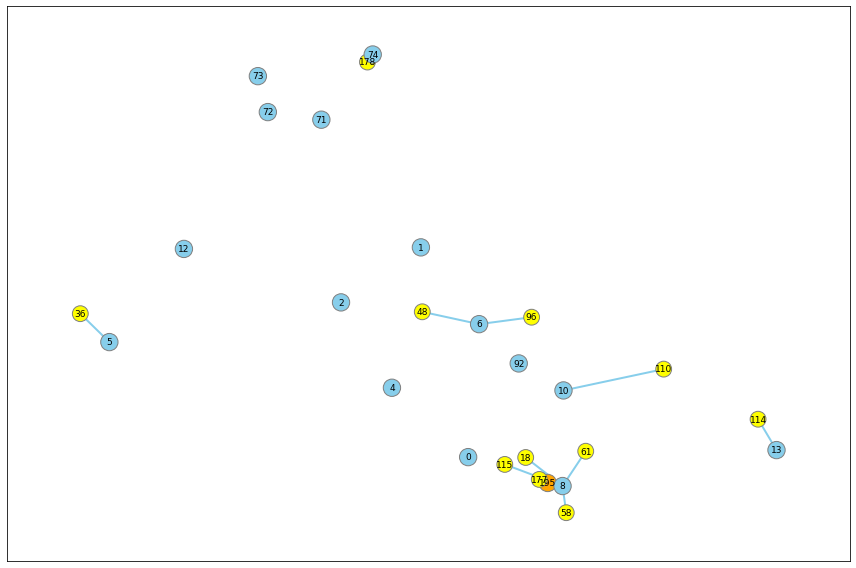

In [185]:
mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
# Sceg.
_plot_cs_ss_connection_graph(
    auxi_model = cs_ss_con_sce_auxi_model, 
    cs_ss_connection_dict = mpdp_connection_dict, 
    sce_Nr = 'mpdp_connection',
    save_fig = True    
        )

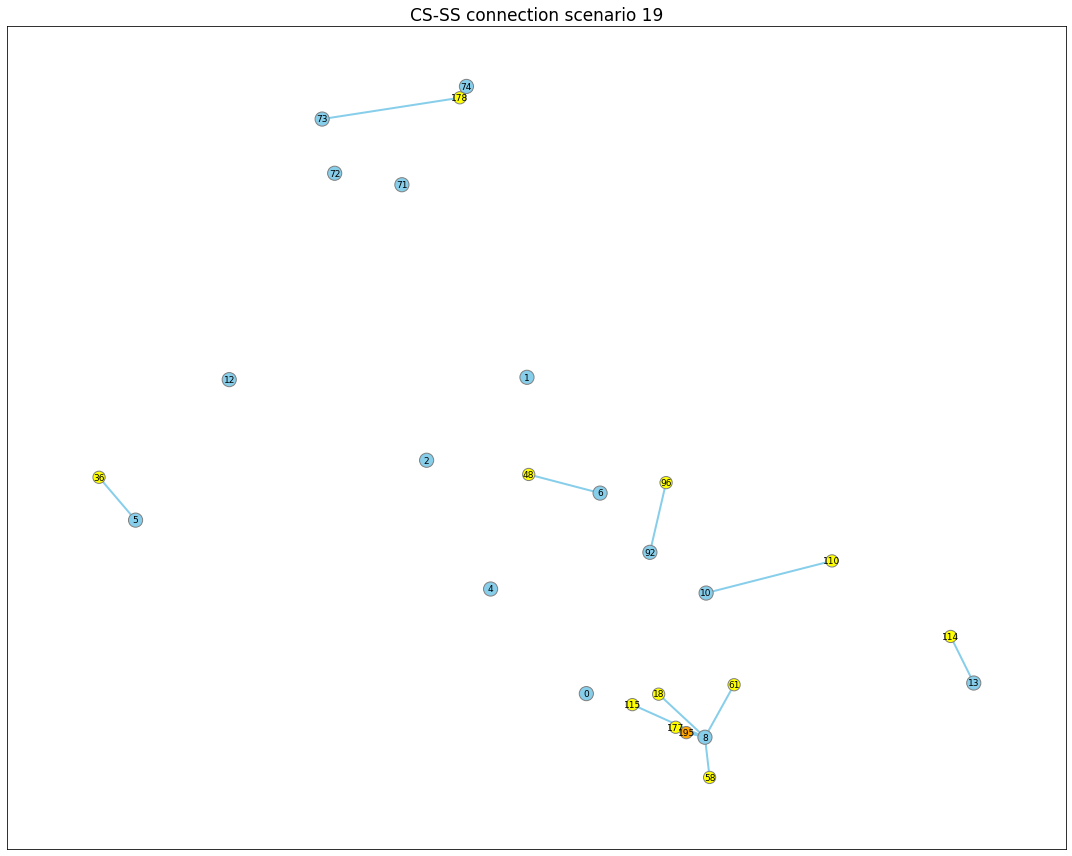

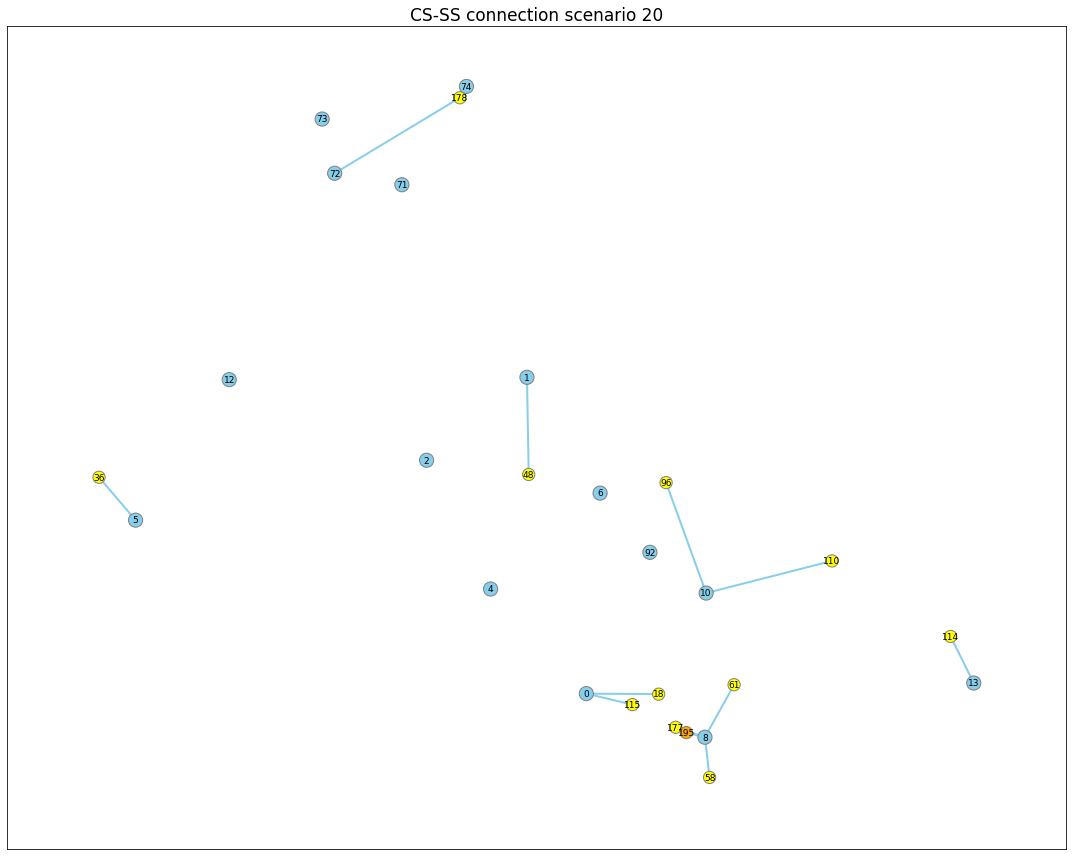

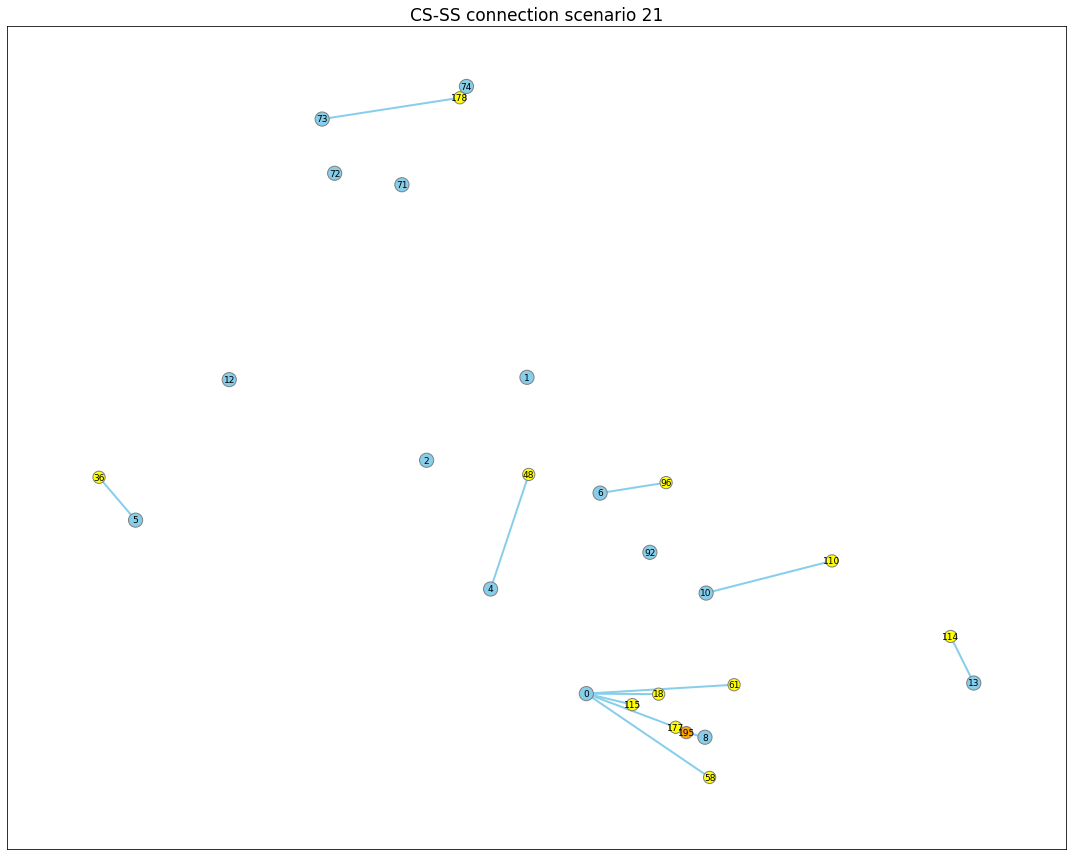

In [117]:
# sce_id = '19'
# # Sceg.
for sce_id in [str(i) for i in range(19,22)]:
#     Sceg.
    _plot_cs_ss_connection_graph(
        cs_ss_con_sce_auxi_model, 
        generated_scenarios, 
        sce_id,
        save_fig = True
        )

## Section 3: Build MPDP frame and extract deterministic data

In [138]:
model_name = 'mpdp_frame_model_4_sp' # assign name to pyomo model, default name set in the setup function is 'CSAP'
csap_is_solved = False
linearize_csap = True
# sce_id = '1'
# connection_sce = all_connection_sces_dict[sce_id].stack().to_dict()

mpdp_frame_model_4_sp = _build_mpdp_csap_frame(    
    setup_dict = csap_setup_dict, 
    cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict(),
    m_name = model_name, 
    linearized = linearize_csap
)

Built an empty concrete pyomo model named mpdp_frame_model_4_sp. 
Defining sets   ...
Parameters_setup 1: Feeding basic parameters to mpdp_frame_model_4_sp ...
Parameters_setup 2: Feeding CS parameters  to 'mpdp_frame_model_4_sp' ...
Parameters_setup 3: Feeding SS parameters to 'mpdp_frame_model_4_sp' ... 
Parameters_setup 4: Feeding CD parameters to mpdp_frame_model_4_sp ... 
 ... 
   Calculating walking distances between candidate locations and CD centers: model.d ...
     Done! Process took 0.81 seconds.
All CD parameters fed! 

Feeding cs-ss connection scenario to model ... 
Feeding decision variables ... 
Defining Expression of Exogenous (Charging) Energy Supply Capability of CSs ...
 Done! Process took 40.57 seconds.
Feeding objective to mpdp_frame_model_4_sp ...

          There are two objectives 'obj_total_profit' and 'obj_profit_no_grid' in frame model.
          Before resolution, use method:
    `model.objective_name.deactive()` to deactive one of them and solve the model w

In [168]:


def _plot_model_graph(
    model: pyo.ConcreteModel, 
    cd_period: str,
    model_is_solved: bool = False,
    with_label: bool = False,
    save_fig: bool = False
    ) -> None:
    """Extract solved/unsolved model information in dictionary for NetworkX plotting

    Args:
        model (pyo.ConcreteModel): _description_
        model_is_solved (bool, optional): _description_. Defaults to False.
    """
    # import networkx as nx
    # print("Extracting model info")
    ## csap.nodes store the coordinates of nodes by (lat, lon) to make the calculation
    ## of distance easier. But to plot, we need the (lon, lat) form.
    nodes_dict = {key: (list(model.nodes[key])[1], list(model.nodes[key])[0]) \
                     for key in model.nodes.keys() }

    # # Remark: use model.Param.extract_values() to get the dictionary of Pyomo Parameters
    max_extraCP_dict = model.m.extract_values()
    existed_CP_dict = model.n.extract_values()

    # Calculate the static charging demand at a POI j for defining the size of node j.
    # # values of this dictionary are 'pyomo expressions', thus we use the second line 
    # # to evaluate them as numeric values
    mpd_static_POIcd_dict = model.fullcd_POI_static.extract_values() 
    mpd_static_POIcd_dict = {key: evaluate_expression(value) for key,value in mpd_static_POIcd_dict.items()}         
    # # keys of mpd_static_POIcd_dict are (j, t), not valid for NX plotting, which
    # # requires (j). Thus we convert it to pd.df and then use .unstack() to get 
    # # POIcd in different periods.
    mpd_static_POIcd_df = pd.Series(
        data = mpd_static_POIcd_dict, 
        index = mpd_static_POIcd_dict.keys()
        ).unstack()    
    period_static_POIcd_dict = mpd_static_POIcd_df[cd_period].dropna().to_dict()

    # candi_locs_list = list(model.I)

    # CS result dicts
    newBuiltCS_nodes_dict = {id_candiLoc: decision for id_candiLoc, decision in \
        model.x.get_values().items() if id_candiLoc in model.I_newBuild and decision > 1e-10}
    updatedCS_nodes_dict = {id_candiLoc: decision for id_candiLoc, decision in \
        model.x.get_values().items() if id_candiLoc in model.I_update and decision > 1e-10}
    
    # SS result dicts
    expandedSS_nodes_dict = {id_SS: decision for id_SS, decision in \
        model.h.get_values().items() if id_SS in model.K and decision > 1e-10}
    # rand_sce_cs_ss_connect_dict = {cs_ss_pair: ob_connected for cs_ss_pair, ob_connected in \
    #     model.Z.extract_values().items() if ob_connected > 1e-10} 
    
    
    # CD result dicts
    # # solution z is very sparse, thus we only pick nonzero values
    # # Get multiperiod cd supply dict by loading csap solutions of $z$.
    mpd_cd_supply_dict = {cs_cd_pair: assigned_cd for cs_cd_pair, assigned_cd in \
        model.z.get_values().items() if assigned_cd > 1e-10} 
    if mpd_cd_supply_dict == {}:
        period_cd_supply_dict = {}
    # # keys of mpd_cd_supply_dict are (i, j, t), not valid for NX plotting, which
    # # requires (i, j). Thus we convert it to pd.df and then use .unstack() to get 
    # # supply in different periods.
    else:
        mpd_cd_supply_df = pd.Series(
            data = mpd_cd_supply_dict, 
            index = mpd_cd_supply_dict.keys()
            ).unstack()
        period_cd_supply_dict = mpd_cd_supply_df[cd_period].dropna().to_dict()        
    
    # POIarrivals_dict = model.CalA.extract_values()
    
    # Get the walking distance between CSs and a POIs for those 
    # # (cs, poi) pairs with covered charging demands
    total_CS2CD_distance_dict = model.d.extract_values()
    cd_supply_distance_dict = {key: round(pyo.value(total_CS2CD_distance_dict.get(key, None))*60, 1) \
                               for key in period_cd_supply_dict.keys()}
    
    
    ###### Define NetworkX conponents: nodes/edges (sizes, colors)# #####
    # print("Definging graph configurations")
    graph = nx.Graph()
    graph.add_nodes_from(nodes_dict.keys())
    edges_list = [*period_cd_supply_dict.keys(), 
#                   *rand_sce_cs_ss_connect_dict.keys()
                  ]
    graph.add_edges_from(edges_list)
    
    node_colors = [
        'red' if node in newBuiltCS_nodes_dict.keys() else \
        'violet' if node in updatedCS_nodes_dict.keys() else \
        'blue' if node in expandedSS_nodes_dict.keys() else \
        'yellow' if node in model.I_newBuild else \
        'orange' if node in model.I_update else \
        'skyblue' if node in model.K else \
            'lightgray' for node in graph.nodes()
    ]
#     edge_colors = ['green' if (id_candi_loci, cd_or_ss) in period_cd_supply_dict.keys()\
#         else 'skyblue' for (id_candi_loci, cd_or_ss) in graph.edges() # CS-SS connection
#         ]
#     edge_colors = ['green' for (id_candi_loci, cd_or_ss) in graph.edges()]
    edge_colors = 'green'

    size_scaler = 2.5 # (CS size scalar)
    POI_size_scaler = 0.02
    SS_size = 30
    if model_is_solved:
        node_sizes = [
            # decision on building new CSs
            model.y[node].value*size_scaler if node in newBuiltCS_nodes_dict else \
            # candi_locs to build new CSs that were NOT choosen 
            max_extraCP_dict[node]*(size_scaler/2) if node in model.I_newBuild else \
            # decision on updating old CSs
            (model.y[node].value + existed_CP_dict[node])*size_scaler if node in updatedCS_nodes_dict else\
            # candi_locs to update old CSs that were NOT choosen
            existed_CP_dict[node]*size_scaler if node in model.I_update else\
                SS_size if node in model.K else\
            # POIarrivals_dict[node]*4 for node in graph.nodes()
            period_static_POIcd_dict[node]*POI_size_scaler for node in graph.nodes()
        ]
    else:
        node_sizes = [
            max_extraCP_dict[node]*size_scaler if node in model.I_newBuild else \
            (max_extraCP_dict[node] + existed_CP_dict[node])*(size_scaler*8) if node in model.I_update else\
                SS_size if node in model.K else\
            # POIarrivals_dict[node]*4 for node in graph.nodes()
            period_static_POIcd_dict[node]*POI_size_scaler for node in graph.nodes()
        ]
    edge_widths = [*(np.array(list(period_cd_supply_dict.values()))*1), 
#                    *(np.array(list(rand_sce_cs_ss_connect_dict.values()))*2)
                   ]
    # for edge,width in zip(edges_list,edge_widths):
    #     print(f"{edge}: {width}")
    
    ##### Plot model graph in NetworkX ##### 
    # print("Plotting ...")
    fig, ax = plt.subplots(figsize=(8,7))
#     ax.set_title(label = f'{cd_period} CD coverage', fontsize = 20)
    nx.draw_networkx_nodes(graph, pos=nodes_dict, ax=ax, 
                        node_color=node_colors,
                        edgecolors=  'black', # '#3070B3' (TUM BLUE) ,# '#009999' (SIEMENS GREEN) , #'green',
                        linewidths = 0.3,
                        node_size=node_sizes,
                        )


    nx.draw_networkx_edges(graph, 
                           pos=nodes_dict, 
                           ax=ax, 
                           node_size=300, arrowsize=30,
                           edge_color=edge_colors, 
                           width=edge_widths
                          )
    if with_label:
        nx.draw_networkx_labels(graph, 
                                pos=nodes_dict, ax=ax, 
                                # labels=dict(zip(nodes_dict.keys(), range(0, len(nodes_dict)))),
                                labels=dict(zip(nodes_dict.keys(), nodes_dict.keys())),
                                font_size=5)    
        nx.draw_networkx_edge_labels(graph, pos=nodes_dict, ax=ax, 
                                     edge_labels=cd_supply_distance_dict,
                                     font_size=4, 
                                     rotate=False
                                     )
#     fig.set_facecolor("#00000F00")
    plt.axis('on')
    plt.tight_layout()
#     plt.grid(axis = 'both', linewidth=0.3)
    plt.show()
    if save_fig:
        now = datetime.now()
        dt_string = now.strftime("%d%m%Y_%H_%M_%S")
        fig.savefig(f'{dt_string}_{cd_period}_.svg', transparent=True)
    

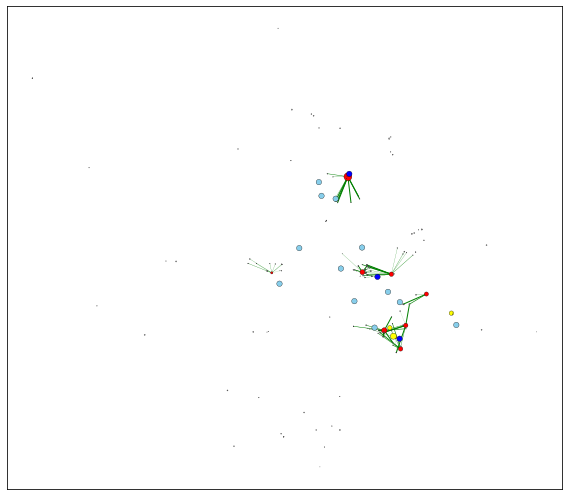

In [171]:
# Dap.
_plot_model_graph(
    model = mpdp_frame_model_4_sp, 
    cd_period = 'night',
    model_is_solved = csap_is_solved,
    save_fig = True
)


In [44]:
unsolved_frame_model_data = SupSP._get_data_from_frame_model(mpdp_frame_model_4_sp)

In [166]:
from pyomo.opt import SolverFactory

mpdp_frame_model_4_sp.obj_profit_no_grid.deactivate()
mpdp_frame_model_4_sp.obj_total_profit.activate()
mpdp_frame_model_4_sp.cons_grid_load_efficientCD.activate()
mpdp_frame_model_4_sp.cons_grid_load_NrCPs.deactivate()
# csap_LP.cons_CDcoverageLB.activate()

Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'cplex_direct'
#     'bonmin'
#     'couenne'
    , tee = True, 
)

solver_results = Solver.solve(mpdp_frame_model_4_sp)
csap_is_solved = True
print("Solver Message:", solver_results)
print_decision = True
if print_decision:
    Stac._print_decision(mpdp_frame_model_4_sp)
#     _print_decision(mpdp_frame_model_4_sp)

Solver Message: 
Problem: 
- Name: tmp97s189q0
  Lower bound: 1599429.40246346
  Upper bound: 1599429.40246346
  Number of objectives: 1
  Number of constraints: 3486
  Number of variables: 6842
  Number of nonzeros: 14704
  Sense: maximize
Solver: 
- Status: ok
  User time: 0.2
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.5994294025e+06
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.4380147457122803
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Decision to build new CSs, 
(loc_id, Nr_CP): 
[(36, 2.0), (48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 7.0), (115, 12.0), (178, 25.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[]
Decision to expand SSs, 
(loc_id, size_expansion): 
[(6, 200.0), (8, 300.0), (74, 100.0)]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amount

In [48]:
solved_frame_model_data = SupSP._get_data_from_frame_model(mpdp_frame_model_4_sp)

In [5]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')
solved_frame_model_data = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_5_SP_converge_test_3PD\solved_frame__data.pickle')
# SAA_convergence_test_results = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\sces500_convergency_test_0412_test.pickle')
# with open('0412_sces500_convergence_another_test_frame_model_data.pickle', 'wb') as f:
#     pickle.dump(frame_model_data, f)
# # frame_model_data
# unsolved_frame_model_data
all_connection_sces_dict = generated_scenarios

In [57]:
all_connection_sces_dict = generated_scenarios

In [54]:
solved_frame_model_data['y']

{195: 0.0,
 18: 0.0,
 36: 2.0,
 48: 10.0,
 58: 8.0,
 61: 8.0,
 96: 8.0,
 110: 7.0,
 114: 0.0,
 115: 12.0,
 177: 0.0,
 178: 25.0}

In [53]:
unsolved_frame_model_data['y']

{195: 0,
 18: 0,
 36: 0,
 48: 0,
 58: 0,
 61: 0,
 96: 0,
 110: 0,
 114: 0,
 115: 0,
 177: 0,
 178: 0}

In [84]:
all_scenario_names = list(all_connection_sces_dict.keys())
selected_sces_names = np.random.choice(all_scenario_names, size = 50, replace = False)
selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)


In [ ]:
selected_sces_names

array(['13947', '17212', '9012', '6013', '15006', '12272', '9078', '6545',
       '8396', '4439', '363', '19374', '3674', '17533', '18256', '9657',
       '11883', '12285', '1769', '1720', '12053', '18594', '5953',
       '19824', '1113', '6088', '14452', '1517', '17961', '5497', '18616',
       '8555', '15862', '13330', '4014', '8180', '9188', '17606', '1170',
       '19244', '971', '2938', '19410', '6438', '2120', '17058', '9177',
       '1490', '12161', '7273'], dtype='<U5')

### No Warm Start

In [ ]:
num_threads = 2 
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
    "threads": num_threads,
    "warmstart": False
}
tic = time.perf_counter()
print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
    You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
csap_ef = ExtensiveForm(options = solver_options, 
    all_scenario_names = selected_sces_names, 
    scenario_creator = Sceg.csap_scenario_creator,
    scenario_creator_kwargs = {
        "mpdp_frame_data": unsolved_frame_model_data,
        "all_sces_dict": selected_connection_sces_dict,
    }
)
toc = time.perf_counter()
print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

print('Solving MPS-MILP')        
tic = time.perf_counter()
solver_results = csap_ef.solve_extensive_form()
# current_obj_val = solver_results['Solution'][0]['Objective']['__default_objective__']['Value']        
toc = time.perf_counter()
# print(solver_results)
print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")


## Store results in the dict
print("Storing test results in dict ... ")
cold_test_results = _get_data_from_solved_MPSP(
    ef_solver_results = solver_results,
    solved_MPSP_extensive_form = csap_ef,    
    num_scenarios = 50,
    ids_scenarios = selected_sces_names,
    )
print('Done\n---------------------------------------\n')

num_threads: 2
Building Stochastic Model with 50 Scenarios. 
    You will see 50 times the same model set-up message. 

[45857.14] Initializing SPBase
Done! set up EVCSAP_MPS_MILP took 2.82 seconds.

Done! set up EVCSAP_MPS_MILP took 2.49 seconds.

Done! set up EVCSAP_MPS_MILP took 2.01 seconds.

Done! set up EVCSAP_MPS_MILP took 2.05 seconds.

Done! set up EVCSAP_MPS_MILP took 2.04 seconds.

Done! set up EVCSAP_MPS_MILP took 2.61 seconds.

Done! set up EVCSAP_MPS_MILP took 7.06 seconds.

Done! set up EVCSAP_MPS_MILP took 1.58 seconds.

Done! set up EVCSAP_MPS_MILP took 1.71 seconds.

Done! set up EVCSAP_MPS_MILP took 1.22 seconds.

Done! set up EVCSAP_MPS_MILP took 1.56 seconds.

Done! set up EVCSAP_MPS_MILP took 1.59 seconds.

Done! set up EVCSAP_MPS_MILP took 1.21 seconds.

Done! set up EVCSAP_MPS_MILP took 1.35 seconds.

Done! set up EVCSAP_MPS_MILP took 1.55 seconds.

Done! set up EVCSAP_MPS_MILP took 1.26 seconds.

Done! set up EVCSAP_MPS_MILP took 9.84 seconds.

Done! set up EVC

### Warm Start

In [87]:
num_threads = 2
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
    "threads": num_threads,
    "warmstart": True
}
tic = time.perf_counter()
print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
    You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
csap_ef = ExtensiveForm(options = solver_options, 
    all_scenario_names = selected_sces_names, 
    scenario_creator = Sceg.csap_scenario_creator,
    scenario_creator_kwargs = {
        "mpdp_frame_data": solved_frame_model_data,
        "all_sces_dict": selected_connection_sces_dict,
    }
)
toc = time.perf_counter()
print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

print('Solving MPS-MILP')        
tic = time.perf_counter()
solver_results = csap_ef.solve_extensive_form()
# current_obj_val = solver_results['Solution'][0]['Objective']['__default_objective__']['Value']        
toc = time.perf_counter()
# print(solver_results)
print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")


## Store results in the dict
print("Storing test results in dict ... ")
# test_results = Stac._get_data_from_solved_MPSP(
warm_test_results = _get_data_from_solved_MPSP(    
    ef_solver_results = solver_results,
    solved_MPSP_extensive_form = csap_ef,    
    num_scenarios = 50,
    ids_scenarios = selected_sces_names,
    )
print('Done\n---------------------------------------\n')

num_threads: 2
Building Stochastic Model with 50 Scenarios. 
    You will see 50 times the same model set-up message. 

[46096.07] Initializing SPBase
Done! set up EVCSAP_MPS_MILP took 1.3 seconds.

Done! set up EVCSAP_MPS_MILP took 1.28 seconds.

Done! set up EVCSAP_MPS_MILP took 1.6 seconds.

Done! set up EVCSAP_MPS_MILP took 1.8 seconds.

Done! set up EVCSAP_MPS_MILP took 1.24 seconds.

Done! set up EVCSAP_MPS_MILP took 1.58 seconds.

Done! set up EVCSAP_MPS_MILP took 1.63 seconds.

Done! set up EVCSAP_MPS_MILP took 1.23 seconds.

Done! set up EVCSAP_MPS_MILP took 1.73 seconds.

Done! set up EVCSAP_MPS_MILP took 1.55 seconds.

Done! set up EVCSAP_MPS_MILP took 1.2 seconds.

Done! set up EVCSAP_MPS_MILP took 1.33 seconds.

Done! set up EVCSAP_MPS_MILP took 1.85 seconds.

Done! set up EVCSAP_MPS_MILP took 1.74 seconds.

Done! set up EVCSAP_MPS_MILP took 1.31 seconds.

Done! set up EVCSAP_MPS_MILP took 2.22 seconds.

Done! set up EVCSAP_MPS_MILP took 2.52 seconds.

Done! set up EVCSAP_

In [91]:
warm_test_results

{'num_scenarios': 50,
 'ids_scenarios': array(['13947', '17212', '9012', '6013', '15006', '12272', '9078', '6545',
        '8396', '4439', '363', '19374', '3674', '17533', '18256', '9657',
        '11883', '12285', '1769', '1720', '12053', '18594', '5953',
        '19824', '1113', '6088', '14452', '1517', '17961', '5497', '18616',
        '8555', '15862', '13330', '4014', '8180', '9188', '17606', '1170',
        '19244', '971', '2938', '19410', '6438', '2120', '17058', '9177',
        '1490', '12161', '7273'], dtype='<U5'),
 'objective_value': 1175296.8087210667,
 'prob_description': {'Lower bound': 1175296.8087210667,
  'Upper bound': 1175408.9633,
  'Number of constraints': 507255,
  'Number of variables': 342051},
 'solver_info': {'User time': 5.59,
  'Termination message': 'MIP - Integer optimal, tolerance (0.0001/1e-06)\\x3a Objective = 1.1752968087e+06',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': 2696, 'Number of created subproblems': 2696}},
  'Time':

In [100]:
print()


- Status: ok
  User time: 5.59
  Termination condition: optimal
  Termination message: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = 1.1752968087e+06
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 2696
      Number of created subproblems: 2696
  Error rc: 0
  Time: 11.484379768371582



In [93]:
objval = csap_ef.get_objective_value()
print(f"Objective value: {objval}")

Objective value: 1175296.8087210653


In [90]:
solution = csap_ef.get_root_solution()
for (var_name, var_value) in solution.items():
    print(var_name, var_value)

'13947'.x[18] 0.0
'13947'.x[36] 0.0
'13947'.x[48] 1.0
'13947'.x[58] 1.0
'13947'.x[61] 1.0
'13947'.x[96] 1.0
'13947'.x[110] 1.0
'13947'.x[114] 1.0
'13947'.x[115] 1.0
'13947'.x[177] 0.0
'13947'.x[178] 1.0
'13947'.x[195] 0.0
'13947'.y[18] 0.0
'13947'.y[36] 0.0
'13947'.y[48] 7.0
'13947'.y[58] 8.0
'13947'.y[61] 8.0
'13947'.y[96] 8.0
'13947'.y[110] 8.0
'13947'.y[114] 16.0
'13947'.y[115] 12.0
'13947'.y[177] 0.0
'13947'.y[178] 11.0
'13947'.y[195] 0.0
'13947'.z[18,15,day_normal] 0.0
'13947'.z[18,15,day_peak] 0.0
'13947'.z[18,15,night] 0.0
'13947'.z[18,16,day_normal] 0.0
'13947'.z[18,16,day_peak] 0.0
'13947'.z[18,16,night] 0.0
'13947'.z[18,17,day_normal] 0.0
'13947'.z[18,17,day_peak] 0.0
'13947'.z[18,17,night] 0.0
'13947'.z[18,19,day_normal] 0.0
'13947'.z[18,19,day_peak] 0.0
'13947'.z[18,19,night] 0.0
'13947'.z[18,20,day_normal] 0.0
'13947'.z[18,20,day_peak] 0.0
'13947'.z[18,20,night] 0.0
'13947'.z[18,21,day_normal] 0.0
'13947'.z[18,21,day_peak] 0.0
'13947'.z[18,21,night] 0.0
'13947'.z[18,22,day

'13947'.z[18,164,day_peak] 0.0
'13947'.z[18,164,night] 0.0
'13947'.z[18,165,day_normal] 0.0
'13947'.z[18,165,day_peak] 0.0
'13947'.z[18,165,night] 0.0
'13947'.z[18,166,day_normal] 0.0
'13947'.z[18,166,day_peak] 0.0
'13947'.z[18,166,night] 0.0
'13947'.z[18,167,day_normal] 0.0
'13947'.z[18,167,day_peak] 0.0
'13947'.z[18,167,night] 0.0
'13947'.z[18,168,day_normal] 0.0
'13947'.z[18,168,day_peak] 0.0
'13947'.z[18,168,night] 0.0
'13947'.z[18,169,day_normal] 0.0
'13947'.z[18,169,day_peak] 0.0
'13947'.z[18,169,night] 0.0
'13947'.z[18,172,day_normal] 0.0
'13947'.z[18,172,day_peak] 0.0
'13947'.z[18,172,night] 0.0
'13947'.z[18,173,day_normal] 0.0
'13947'.z[18,173,day_peak] 0.0
'13947'.z[18,173,night] 0.0
'13947'.z[18,174,day_normal] 0.0
'13947'.z[18,174,day_peak] 0.0
'13947'.z[18,174,night] 0.0
'13947'.z[18,175,day_normal] 0.0
'13947'.z[18,175,day_peak] 0.0
'13947'.z[18,175,night] 0.0
'13947'.z[18,176,day_normal] 0.0
'13947'.z[18,176,day_peak] 0.0
'13947'.z[18,176,night] 0.0
'13947'.z[18,180,day_

'13947'.z[48,62,night] 0.0
'13947'.z[48,63,day_normal] 0.0
'13947'.z[48,63,day_peak] 0.0
'13947'.z[48,63,night] 0.0
'13947'.z[48,64,day_normal] 0.0
'13947'.z[48,64,day_peak] 0.0
'13947'.z[48,64,night] 0.0
'13947'.z[48,65,day_normal] 0.0
'13947'.z[48,65,day_peak] 0.0
'13947'.z[48,65,night] 0.0
'13947'.z[48,66,day_normal] 0.0
'13947'.z[48,66,day_peak] 0.0
'13947'.z[48,66,night] 0.0
'13947'.z[48,67,day_normal] 0.0
'13947'.z[48,67,day_peak] 0.0
'13947'.z[48,67,night] 0.0
'13947'.z[48,68,day_normal] 0.0
'13947'.z[48,68,day_peak] 0.0
'13947'.z[48,68,night] 0.0
'13947'.z[48,69,day_normal] 0.0
'13947'.z[48,69,day_peak] 0.0
'13947'.z[48,69,night] 0.0
'13947'.z[48,70,day_normal] 0.0
'13947'.z[48,70,day_peak] 0.0
'13947'.z[48,70,night] 0.0
'13947'.z[48,75,day_normal] 0.0
'13947'.z[48,75,day_peak] 0.0
'13947'.z[48,75,night] 0.0
'13947'.z[48,76,day_normal] 0.0
'13947'.z[48,76,day_peak] 0.0
'13947'.z[48,76,night] 0.0
'13947'.z[48,77,day_normal] 0.0
'13947'.z[48,77,day_peak] 0.0
'13947'.z[48,77,night

'13947'.z[58,186,day_normal] 0.0
'13947'.z[58,186,day_peak] 0.0
'13947'.z[58,186,night] 0.0
'13947'.z[58,187,day_normal] 0.0
'13947'.z[58,187,day_peak] 0.0
'13947'.z[58,187,night] 0.0
'13947'.z[58,188,day_normal] 0.0
'13947'.z[58,188,day_peak] 0.0
'13947'.z[58,188,night] 0.0
'13947'.z[58,189,day_normal] 0.0
'13947'.z[58,189,day_peak] 0.0
'13947'.z[58,189,night] 0.0
'13947'.z[58,190,day_normal] 0.0
'13947'.z[58,190,day_peak] 0.0
'13947'.z[58,190,night] 0.0
'13947'.z[58,191,day_normal] 0.0
'13947'.z[58,191,day_peak] 0.0
'13947'.z[58,191,night] 0.0
'13947'.z[58,192,day_normal] 0.0
'13947'.z[58,192,day_peak] 0.0
'13947'.z[58,192,night] 0.0
'13947'.z[58,193,day_normal] 0.23413392725555834
'13947'.z[58,193,day_peak] 0.13668258901474817
'13947'.z[58,193,night] 0.0
'13947'.z[58,194,day_normal] 1.0
'13947'.z[58,194,day_peak] 0.08349349246018084
'13947'.z[58,194,night] 0.0
'13947'.z[61,15,day_normal] 0.0
'13947'.z[61,15,day_peak] 0.0
'13947'.z[61,15,night] 0.0
'13947'.z[61,16,day_normal] 0.0
'13

'13947'.z[96,111,night] 0.0
'13947'.z[96,112,day_normal] 0.0
'13947'.z[96,112,day_peak] 0.0
'13947'.z[96,112,night] 0.0
'13947'.z[96,113,day_normal] 0.0
'13947'.z[96,113,day_peak] 0.0
'13947'.z[96,113,night] 0.0
'13947'.z[96,116,day_normal] 0.08437217744277602
'13947'.z[96,116,day_peak] 0.05212730023628573
'13947'.z[96,116,night] 0.13303849818865215
'13947'.z[96,117,day_normal] 0.08500141631941319
'13947'.z[96,117,day_peak] 0.04649915190437142
'13947'.z[96,117,night] 0.0
'13947'.z[96,118,day_normal] 0.07667011618924092
'13947'.z[96,118,day_peak] 0.049332204658264746
'13947'.z[96,118,night] 1.0
'13947'.z[96,119,day_normal] 0.0838660080400742
'13947'.z[96,119,day_peak] 0.05299023845428532
'13947'.z[96,119,night] 0.0
'13947'.z[96,120,day_normal] 1.0
'13947'.z[96,120,day_peak] 0.05299023845428532
'13947'.z[96,120,night] 0.0
'13947'.z[96,121,day_normal] 0.09270635928905285
'13947'.z[96,121,day_peak] 0.057302900836430026
'13947'.z[96,121,night] 0.14750373501828287
'13947'.z[96,122,day_normal

'13947'.z[110,24,day_normal] 0.0
'13947'.z[110,24,day_peak] 0.0
'13947'.z[110,24,night] 0.0
'13947'.z[110,25,day_normal] 0.0
'13947'.z[110,25,day_peak] 0.0
'13947'.z[110,25,night] 0.0
'13947'.z[110,26,day_normal] 0.0
'13947'.z[110,26,day_peak] 0.0
'13947'.z[110,26,night] 0.0
'13947'.z[110,27,day_normal] 0.0
'13947'.z[110,27,day_peak] 0.0
'13947'.z[110,27,night] 0.0
'13947'.z[110,28,day_normal] 0.0
'13947'.z[110,28,day_peak] 0.0
'13947'.z[110,28,night] 0.0
'13947'.z[110,29,day_normal] 0.0
'13947'.z[110,29,day_peak] 0.0
'13947'.z[110,29,night] 0.0
'13947'.z[110,30,day_normal] 0.0
'13947'.z[110,30,day_peak] 0.0
'13947'.z[110,30,night] 0.0
'13947'.z[110,31,day_normal] 0.0
'13947'.z[110,31,day_peak] 0.0
'13947'.z[110,31,night] 0.0
'13947'.z[110,32,day_normal] 0.8561010019980975
'13947'.z[110,32,day_peak] 0.25620623851399643
'13947'.z[110,32,night] 0.5705247717195854
'13947'.z[110,33,day_normal] 0.0
'13947'.z[110,33,day_peak] 0.0
'13947'.z[110,33,night] 0.0
'13947'.z[110,34,day_normal] 0.0
'

'13947'.z[114,56,day_normal] 0.0
'13947'.z[114,56,day_peak] 0.0
'13947'.z[114,56,night] 0.0
'13947'.z[114,57,day_normal] 0.0
'13947'.z[114,57,day_peak] 0.0
'13947'.z[114,57,night] 0.0
'13947'.z[114,59,day_normal] 0.0
'13947'.z[114,59,day_peak] 0.0
'13947'.z[114,59,night] 0.0
'13947'.z[114,60,day_normal] 0.0
'13947'.z[114,60,day_peak] 0.0
'13947'.z[114,60,night] 0.0
'13947'.z[114,62,day_normal] 0.0
'13947'.z[114,62,day_peak] 0.0
'13947'.z[114,62,night] 0.0
'13947'.z[114,63,day_normal] 0.0
'13947'.z[114,63,day_peak] 0.0
'13947'.z[114,63,night] 0.0
'13947'.z[114,64,day_normal] 0.0
'13947'.z[114,64,day_peak] 0.0
'13947'.z[114,64,night] 0.0
'13947'.z[114,65,day_normal] 0.0
'13947'.z[114,65,day_peak] 0.0
'13947'.z[114,65,night] 0.0
'13947'.z[114,66,day_normal] 0.0
'13947'.z[114,66,day_peak] 0.0
'13947'.z[114,66,night] 0.0
'13947'.z[114,67,day_normal] 0.0
'13947'.z[114,67,day_peak] 0.0
'13947'.z[114,67,night] 0.0
'13947'.z[114,68,day_normal] 0.0
'13947'.z[114,68,day_peak] 0.0
'13947'.z[114,68

'13947'.z[114,157,day_peak] 0.0
'13947'.z[114,157,night] 0.0
'13947'.z[114,158,day_normal] 0.0
'13947'.z[114,158,day_peak] 0.0
'13947'.z[114,158,night] 0.0
'13947'.z[114,159,day_normal] 0.0
'13947'.z[114,159,day_peak] 0.0
'13947'.z[114,159,night] 0.0
'13947'.z[114,160,day_normal] 0.0
'13947'.z[114,160,day_peak] 0.0
'13947'.z[114,160,night] 0.0
'13947'.z[114,161,day_normal] 0.0
'13947'.z[114,161,day_peak] 0.0
'13947'.z[114,161,night] 0.0
'13947'.z[114,162,day_normal] 0.0
'13947'.z[114,162,day_peak] 0.0
'13947'.z[114,162,night] 0.0
'13947'.z[114,163,day_normal] 0.0
'13947'.z[114,163,day_peak] 0.0
'13947'.z[114,163,night] 0.0
'13947'.z[114,164,day_normal] 0.0
'13947'.z[114,164,day_peak] 0.0
'13947'.z[114,164,night] 0.0
'13947'.z[114,165,day_normal] 0.0
'13947'.z[114,165,day_peak] 0.0
'13947'.z[114,165,night] 0.0
'13947'.z[114,166,day_normal] 0.0
'13947'.z[114,166,day_peak] 0.0
'13947'.z[114,166,night] 0.0
'13947'.z[114,167,day_normal] 0.0
'13947'.z[114,167,day_peak] 0.0
'13947'.z[114,167,

'13947'.z[177,21,day_normal] 0.0
'13947'.z[177,21,day_peak] 0.0
'13947'.z[177,21,night] 0.0
'13947'.z[177,22,day_normal] 0.0
'13947'.z[177,22,day_peak] 0.0
'13947'.z[177,22,night] 0.0
'13947'.z[177,23,day_normal] 0.0
'13947'.z[177,23,day_peak] 0.0
'13947'.z[177,23,night] 0.0
'13947'.z[177,24,day_normal] 0.0
'13947'.z[177,24,day_peak] 0.0
'13947'.z[177,24,night] 0.0
'13947'.z[177,25,day_normal] 0.0
'13947'.z[177,25,day_peak] 0.0
'13947'.z[177,25,night] 0.0
'13947'.z[177,26,day_normal] 0.0
'13947'.z[177,26,day_peak] 0.0
'13947'.z[177,26,night] 0.0
'13947'.z[177,27,day_normal] 0.0
'13947'.z[177,27,day_peak] 0.0
'13947'.z[177,27,night] 0.0
'13947'.z[177,28,day_normal] 0.0
'13947'.z[177,28,day_peak] 0.0
'13947'.z[177,28,night] 0.0
'13947'.z[177,29,day_normal] 0.0
'13947'.z[177,29,day_peak] 0.0
'13947'.z[177,29,night] 0.0
'13947'.z[177,30,day_normal] 0.0
'13947'.z[177,30,day_peak] 0.0
'13947'.z[177,30,night] 0.0
'13947'.z[177,31,day_normal] 0.0
'13947'.z[177,31,day_peak] 0.0
'13947'.z[177,31

'13947'.z[177,149,day_normal] 0.0
'13947'.z[177,149,day_peak] 0.0
'13947'.z[177,149,night] 0.0
'13947'.z[177,150,day_normal] 0.0
'13947'.z[177,150,day_peak] 0.0
'13947'.z[177,150,night] 0.0
'13947'.z[177,151,day_normal] 0.0
'13947'.z[177,151,day_peak] 0.0
'13947'.z[177,151,night] 0.0
'13947'.z[177,152,day_normal] 0.0
'13947'.z[177,152,day_peak] 0.0
'13947'.z[177,152,night] 0.0
'13947'.z[177,153,day_normal] 0.0
'13947'.z[177,153,day_peak] 0.0
'13947'.z[177,153,night] 0.0
'13947'.z[177,154,day_normal] 0.0
'13947'.z[177,154,day_peak] 0.0
'13947'.z[177,154,night] 0.0
'13947'.z[177,155,day_normal] 0.0
'13947'.z[177,155,day_peak] 0.0
'13947'.z[177,155,night] 0.0
'13947'.z[177,156,day_normal] 0.0
'13947'.z[177,156,day_peak] 0.0
'13947'.z[177,156,night] 0.0
'13947'.z[177,157,day_normal] 0.0
'13947'.z[177,157,day_peak] 0.0
'13947'.z[177,157,night] 0.0
'13947'.z[177,158,day_normal] 0.0
'13947'.z[177,158,day_peak] 0.0
'13947'.z[177,158,night] 0.0
'13947'.z[177,159,day_normal] 0.0
'13947'.z[177,15

'13947'.z[178,102,day_normal] 0.0
'13947'.z[178,102,day_peak] 0.0
'13947'.z[178,102,night] 0.0
'13947'.z[178,103,day_normal] 0.0
'13947'.z[178,103,day_peak] 0.0
'13947'.z[178,103,night] 0.0
'13947'.z[178,104,day_normal] 0.0
'13947'.z[178,104,day_peak] 0.0
'13947'.z[178,104,night] 0.0
'13947'.z[178,105,day_normal] 0.25020660383938126
'13947'.z[178,105,day_peak] 0.13562850877304963
'13947'.z[178,105,night] 1.0
'13947'.z[178,106,day_normal] 0.0
'13947'.z[178,106,day_peak] 0.0
'13947'.z[178,106,night] 0.0
'13947'.z[178,107,day_normal] 0.0
'13947'.z[178,107,day_peak] 0.0
'13947'.z[178,107,night] 0.0
'13947'.z[178,108,day_normal] 0.0
'13947'.z[178,108,day_peak] 0.0
'13947'.z[178,108,night] 0.0
'13947'.z[178,109,day_normal] 0.0
'13947'.z[178,109,day_peak] 0.0
'13947'.z[178,109,night] 0.0
'13947'.z[178,111,day_normal] 0.0
'13947'.z[178,111,day_peak] 0.0
'13947'.z[178,111,night] 0.0
'13947'.z[178,112,day_normal] 0.0
'13947'.z[178,112,day_peak] 0.0
'13947'.z[178,112,night] 0.0
'13947'.z[178,113,

'13947'.z[195,70,night] 0.0
'13947'.z[195,75,day_normal] 0.0
'13947'.z[195,75,day_peak] 0.0
'13947'.z[195,75,night] 0.0
'13947'.z[195,76,day_normal] 0.0
'13947'.z[195,76,day_peak] 0.0
'13947'.z[195,76,night] 0.0
'13947'.z[195,77,day_normal] 0.0
'13947'.z[195,77,day_peak] 0.0
'13947'.z[195,77,night] 0.0
'13947'.z[195,78,day_normal] 0.0
'13947'.z[195,78,day_peak] 0.0
'13947'.z[195,78,night] 0.0
'13947'.z[195,79,day_normal] 0.0
'13947'.z[195,79,day_peak] 0.0
'13947'.z[195,79,night] 0.0
'13947'.z[195,80,day_normal] 0.0
'13947'.z[195,80,day_peak] 0.0
'13947'.z[195,80,night] 0.0
'13947'.z[195,81,day_normal] 0.0
'13947'.z[195,81,day_peak] 0.0
'13947'.z[195,81,night] 0.0
'13947'.z[195,82,day_normal] 0.0
'13947'.z[195,82,day_peak] 0.0
'13947'.z[195,82,night] 0.0
'13947'.z[195,83,day_normal] 0.0
'13947'.z[195,83,day_peak] 0.0
'13947'.z[195,83,night] 0.0
'13947'.z[195,84,day_normal] 0.021869341162379152
'13947'.z[195,84,day_peak] 0.0
'13947'.z[195,84,night] 0.0
'13947'.z[195,85,day_normal] 0.0
'1

'13947'.chi[51,day_peak] 60.14526598974314
'13947'.chi[51,night] 8.81377348040769
'13947'.chi[52,day_normal] 0.0
'13947'.chi[52,day_peak] 0.0
'13947'.chi[52,night] 0.0
'13947'.chi[53,day_normal] 0.0
'13947'.chi[53,day_peak] 0.0
'13947'.chi[53,night] 0.0
'13947'.chi[54,day_normal] 7.435166716159648
'13947'.chi[54,day_peak] 4.153908659662145
'13947'.chi[54,night] 0.160170608868705
'13947'.chi[55,day_normal] 10.856989668671648
'13947'.chi[55,day_peak] 2.965267618889561
'13947'.chi[55,night] 1.1924314580568192
'13947'.chi[56,day_normal] 100.99848221858397
'13947'.chi[56,day_peak] 35.008741728511865
'13947'.chi[56,night] 13.882845021205377
'13947'.chi[57,day_normal] 141.76157258156707
'13947'.chi[57,day_peak] 30.392397576783395
'13947'.chi[57,night] 8.962307312135174
'13947'.chi[59,day_normal] 0.0
'13947'.chi[59,day_peak] 0.0
'13947'.chi[59,night] 0.0
'13947'.chi[60,day_normal] 0.0
'13947'.chi[60,day_peak] 0.0
'13947'.chi[60,night] 0.0
'13947'.chi[62,day_normal] 0.0
'13947'.chi[62,day_peak]

'13947'.chi[163,night] 0.0
'13947'.chi[164,day_normal] 0.0
'13947'.chi[164,day_peak] 0.0
'13947'.chi[164,night] 0.0
'13947'.chi[165,day_normal] 0.0
'13947'.chi[165,day_peak] 0.0
'13947'.chi[165,night] 0.0
'13947'.chi[166,day_normal] 0.0
'13947'.chi[166,day_peak] 0.0
'13947'.chi[166,night] 0.0
'13947'.chi[167,day_normal] 0.0
'13947'.chi[167,day_peak] 0.0
'13947'.chi[167,night] 0.0
'13947'.chi[168,day_normal] 0.0
'13947'.chi[168,day_peak] 0.0
'13947'.chi[168,night] 0.0
'13947'.chi[169,day_normal] 0.0
'13947'.chi[169,day_peak] 0.0
'13947'.chi[169,night] 0.0
'13947'.chi[172,day_normal] 12.257960911823696
'13947'.chi[172,day_peak] 2.200830369596685
'13947'.chi[172,night] 0.667067534663324
'13947'.chi[173,day_normal] 0.0
'13947'.chi[173,day_peak] 0.0
'13947'.chi[173,night] 0.0
'13947'.chi[174,day_normal] 12.046173588165935
'13947'.chi[174,day_peak] 7.782784934928703
'13947'.chi[174,night] 2.499269023782461
'13947'.chi[175,day_normal] 350.23471434772074
'13947'.chi[175,day_peak] 34.5169043261

'13947'.calE[97,day_peak] 0.0
'13947'.calE[97,night] 0.0
'13947'.calE[98,day_normal] 0.0
'13947'.calE[98,day_peak] 0.0
'13947'.calE[98,night] 0.0
'13947'.calE[99,day_normal] 0.0
'13947'.calE[99,day_peak] 0.0
'13947'.calE[99,night] 0.0
'13947'.calE[100,day_normal] 0.0
'13947'.calE[100,day_peak] 0.0
'13947'.calE[100,night] 0.0
'13947'.calE[102,day_normal] 0.0
'13947'.calE[102,day_peak] 0.0
'13947'.calE[102,night] 0.0
'13947'.calE[103,day_normal] 0.0
'13947'.calE[103,day_peak] 0.0
'13947'.calE[103,night] 0.0
'13947'.calE[104,day_normal] 0.0
'13947'.calE[104,day_peak] 0.0
'13947'.calE[104,night] 0.0
'13947'.calE[105,day_normal] 0.0
'13947'.calE[105,day_peak] 0.0
'13947'.calE[105,night] 0.0
'13947'.calE[106,day_normal] 0.0
'13947'.calE[106,day_peak] 0.0
'13947'.calE[106,night] 0.0
'13947'.calE[107,day_normal] 0.0
'13947'.calE[107,day_peak] 0.0
'13947'.calE[107,night] 0.0
'13947'.calE[108,day_normal] 0.0
'13947'.calE[108,day_peak] 0.0
'13947'.calE[108,night] 0.0
'13947'.calE[109,day_normal] 

# Convergence Test

In [3]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')
solved_frame_model_data = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_5_SP_converge_test_3PD\solved_frame_model_data.pickle')
# SAA_convergence_test_results = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\sces500_convergency_test_0412_test.pickle')
# with open('0412_sces500_convergence_another_test_frame_model_data.pickle', 'wb') as f:
#     pickle.dump(frame_model_data, f)
# # frame_model_data
# unsolved_frame_model_data
all_connection_sces_dict = generated_scenarios

In [6]:
type(list(all_connection_sces_dict.keys())[0])

str

In [4]:
# conv_test_300_226 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_temp_save_300_to_226.pickle')
# conv_test_300_226

In [5]:
num_sces_list_addi =[12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28,29,30, 32, 33, 34]
dummy_sces_list = [2]

In [6]:
# num_sces_list_0 = [36, 40, 44, 48, 52, 56, 60, 61, 71, 81, 91]
# num_sces_list_2 = [226, 251, 276] # 300
# num_sces_list_3 = [450]
num_sces_list_4 = [500]

In [9]:
num_sces = 10
all_scenario_names = list(all_connection_sces_dict.keys())
selected_sces_names = np.random.choice(all_scenario_names, size = num_sces, replace = False)
selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)

In [8]:
useful_description_info_list = ['Lower bound', 'Upper bound', 'Number of constraints', 'Number of variables']
useful_solver_info_list = ['User time', 'Termination message', 'Statistics', 'Time' ]
num_threads = 2
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
    "threads": num_threads,
    "warmstart": True
}
SAA_convergence_test_dict = dict()
# num_sces = 1
# test_id = 1
last_obj_val = -1e+20
obj_diff_criteria = 100
all_scenario_names = list(all_connection_sces_dict.keys())
error_exists = False
last_time = time.perf_counter() # Used for check point save

# num_sces_list_1 = np.array([1,2,3,4,5]) # , 7,10,20, 35, 70, 150, 220, 300, 400, 550])
# # num_sces_list_2 = np.array([6, 8, 9, 15, 25, 50, 100])
# # num_sces_list_3 = np.array([12, 13, 14, 16, 17, 18, 19, 22, 27,30])

# for num_threads in (2,8):
# while num_sces <= 10:
for num_sces in dummy_sces_list:
    test_id = f"{num_sces}_sces_test"
    try:
        print('---------------------------------------\nInitializing solver options and scenarios ...')

        # Sampling (selecting) `num_sces` connection scenarios for SP
        selected_sces_names = np.random.choice(all_scenario_names, size = num_sces, replace = False)
        selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)

        tic = time.perf_counter()
        print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
            You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
        csap_ef = ExtensiveForm(options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs = {
                "mpdp_frame_data": solved_frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
        )
        toc = time.perf_counter()
        print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

        print('Solving MPS-MILP')        
        tic = time.perf_counter()
        solver_results = csap_ef.solve_extensive_form()
        current_obj_val = solver_results['Solution'][0]['Objective']['__default_objective__']['Value']        
        toc = time.perf_counter()
        print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")

        ## Store results in the dict
        print("Storing test results in dict ... ")
        SAA_convergence_test_dict[test_id] = Stac._get_data_from_solved_MPSP(
            ef_solver_results = solver_results,
            solved_MPSP_extensive_form = csap_ef,    
            num_scenarios = num_sces,
            ids_scenarios = selected_sces_names,
            )
        print('Done\n---------------------------------------\n')

        if np.abs(current_obj_val - last_obj_val) <= obj_diff_criteria:
            # add early stop # 
            print("Converged by obj_diff_criteria")
            SAA_convergence_test_dict['Stop'] = f'diff_obj_less_than_{obj_diff_criteria}'
            break
        last_obj_val = current_obj_val
#         num_sces += test_id*3
#         test_id += 1
    except Exception as e:
        error_exists = True
        print(f"Got error with {test_id}")
        print(e)
        SAA_convergence_test_dict['Stop'] = str(e)
#         with open('Exception_1301_dict_conv_test_addi.pickle', 'wb') as f:
#             pickle.dump(SAA_convergence_test_dict, f)
        print('Saved test results as .pickle file under Exception and Stopped')
        break
    current_time = time.perf_counter()
    if current_time - last_time > 900:
#         with open(f'dict_conv_test_1301_Samples_temp_save_addi.pickle', 'wb') as f:
#             pickle.dump(SAA_convergence_test_dict, f)        
        print(f'More than 900 seconds passed, save results so far till num_sces {num_sces} in a .pickle file, test continues')
        last_time = current_time
        


if not error_exists:
    SAA_convergence_test_dict['Stop'] = f'Solved all scenarios'
#     with open('dict_conv_test_1301_Samples_addi.pickle', 'wb') as f:
#         pickle.dump(SAA_convergence_test_dict, f)        
    print('Savevd Results as .pickle file, Convergence Test Done')

SyntaxError: invalid syntax (982236693.py, line 81)

In [42]:

def _get_data_from_solved_MPSP(
    ef_solver_results,
    solved_MPSP_extensive_form,    
    num_scenarios: int,
    ids_scenarios: np.array,
    ) -> dict:
    """Get data and information from solved multi-period stochastic programming EVCSAP. 

    Args:
        ef_solver_results (_type_): _description_
        solved_MPSP_extensive_form (_type_): _description_
        num_scenarios (int): _description_
        ids_scenarios (np.array): _description_

    Returns:
        dict: _description_
    """
    # Check solver_results, if model is unsolved, return Error.
    assert ef_solver_results.solver.status == 'ok', '''Cannot save unsolved model results.'''
    
    # Initialize useful information to save
    useful_description_info_list = ['Lower bound', 'Upper bound', 'Number of constraints', 'Number of variables']
    useful_solver_info_list = ['User time', 'Termination message', 'Statistics', 'Time' ]
    
    #  ------------ Get `first-stage decisions` from solved_MPSP_extensive_form ------------ #
    mpsp_raw_soln = solved_MPSP_extensive_form.get_root_solution()
    mpsp_decisions = _get_mpsp_strategy_decision(mpsp_raw_solution = mpsp_raw_soln)

    # ----------------------- Extract Info from Subscenario Model -------------------------- #
    # Generate a solved_sub_scenario_model from the subsce_model generator of MPSP_extensive_form
    csap_subsces_generator = solved_MPSP_extensive_form.scenarios()
    subsce_name, subscemodel = next(csap_subsces_generator)
    # extract information from solved_sub_scenario_model 
    SP_one_subscemodel_data = _get_data_from_frame_model(frame_model = subscemodel)
    # extract a group of `second-stage decisions` from ONE SINGLE specific sub scenario model. 
    SP_one_subscemodel_data[f"{subsce_name}.eta"] = subscemodel.eta.get_values()    

    # Get different obj costs from solved_sub_scenario_model
    obj_components = [
        subscemodel.obj_total_profit, 
        subscemodel.cs_placement_cost, 
        subscemodel.grid_expansion_cost, 
        subscemodel.backstop_tech_cost_sp, 
        subscemodel.gross_revenue,
        subscemodel.cs_placement_cost + subscemodel.grid_expansion_cost - subscemodel.gross_revenue
    ]
    obj_components_name = [
        'obj_total_profit',
        'cs_placement_cost', 
        'grid_expansion_cost', 
        'backstop_tech_cost_sp', 
        'gross_revenue',
        'first_stage_cost',
    ]      
    obj_val_dict = {obj_components_name[idx]:pyo.value(obj_Expr) for idx, obj_Expr in enumerate(obj_components)}           

    # ------------------ Get ef_solver_results for MPSP ----------------- #
    results_prob_descrip = ef_solver_results['Problem'][0]
    results_solver_info = ef_solver_results['Solver'][0]
    obj_val = ef_solver_results['Solution'][0]['Objective']['__default_objective__']['Value']
    
    # print("Storing test results ... ")        
    test_result_dict = {
        'num_scenarios': num_scenarios,
        'ids_scenarios': ids_scenarios,
        'objective_value' : obj_val,
        'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
        'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
        'gap' : ef_solver_results['Solution'][0]['Gap'],    
        'mpsp_csap_decisions': mpsp_decisions,
        f"subsce_{subsce_name}_data" : {**obj_val_dict,
            **SP_one_subscemodel_data 
        }
    }
    # print("Done!")
    return test_result_dict


def _get_mpsp_strategy_decision(mpsp_raw_solution: dict):
    """This method is used for convergence test of SP to get filtered/cleaned readable solutions from the raw_solution generated by mpi-sppy. Raw_solution is the solution to the extensive form of a stochastic model. 

    Args:
        mpsp_raw_solution (dict): solutions generated by mpi-sppy ExtensiveForm method.
    """
    strategy_dv_list = ['x', 'y', 'h', 'z']
    sp_sol_dict = dict()
    for dv in strategy_dv_list:
        sp_sol_dict[dv] = dict()
    # print(sp_sol_dict)
    # Extract non-zero strategy decisions 
    for (dv_name, dv_val) in mpsp_raw_solution.items():
        # Extract variables name from strings of raw solutions .
        name_pos = dv_name.find(".") + 1
        id_pos = dv_name.find("[")
        id_end_pos = dv_name.find("]")
        var_vect_name = dv_name[name_pos:id_pos]
        # print(var_vect_name)
        if dv_val > 1e-10 and var_vect_name in strategy_dv_list:
#             print(sp_sol_dict[var_vect_name][dv_name[id_pos+1:id_end_pos]])
            sp_sol_dict[var_vect_name][dv_name[id_pos+1:id_end_pos]] = dv_val
    print(sp_sol_dict)
    return sp_sol_dict


In [43]:
# SAA_convergence_test_dict[test_id] = Stac._get_data_from_solved_MPSP(
SAA_convergence_test_dict[test_id] = _get_data_from_solved_MPSP(    
    ef_solver_results = solver_results,
    solved_MPSP_extensive_form = csap_ef,    
    num_scenarios = num_sces,
    ids_scenarios = selected_sces_names,
    )

{'x': {}, 'y': {}, 'h': {}, 'z': {}, 'eta': {}}
{'x': {'36': 1.0, '48': 1.0, '58': 1.0, '61': 1.0, '96': 1.0, '110': 1.0, '115': 1.0, '178': 1.0}, 'y': {'36': 2.0, '48': 10.0, '58': 8.0, '61': 8.0, '96': 8.0, '110': 7.0, '115': 12.0, '178': 25.0}, 'h': {'0': 6.0, '2': 2.0, '8': 3.0, '73': 2.0, '92': 1.0}, 'z': {'36,16,day_normal': 0.04498302234188511, '36,16,day_peak': 0.012448592880158765, '36,16,night': 0.08486467476639506, '36,17,day_normal': 0.024864826301992764, '36,17,day_peak': 0.012448592880158767, '36,17,night': 0.08486467476639507, '36,22,day_normal': 0.02257982769393913, '36,22,day_peak': 0.01130460671038169, '36,22,night': 0.07706588054362605, '36,23,day_normal': 0.022579827693939136, '36,23,day_peak': 0.011304606710381686, '36,23,night': 0.07706588054362604, '36,88,day_normal': 0.025931346433986778, '36,88,day_peak': 0.012982546938813204, '36,88,night': 0.0885047518388913, '36,89,day_normal': 0.025931346433986775, '36,89,day_peak': 0.012982546938813207, '36,89,night': 0.08

NameError: name '_get_data_from_frame_model' is not defined

In [173]:
SAA_convergence_test_results_1_35 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_1_35.pickle')
SAA_convergence_test_results_addi = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_addi.pickle')
SAA_convergence_test_results_36_100 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_36_100.pickle')
SAA_convergence_test_results_101_201 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_101_201.pickle')
SAA_convergence_test_results_226_276 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_226_276.pickle')
SAA_convergence_test_results_300 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_300.pickle')
SAA_convergence_test_results_350_400 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_350_400.pickle')
SAA_convergence_test_results_450 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_450.pickle')
SAA_convergence_test_results_500 = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\\v_test_5_SP_converge_test_3PD\dict_conv_test_1301_Samples_500.pickle')

conc_SAA_convergence_500test_results = {
    **SAA_convergence_test_results_1_35, 
    **SAA_convergence_test_results_addi,
    **SAA_convergence_test_results_36_100, 
    **SAA_convergence_test_results_101_201, 
    **SAA_convergence_test_results_226_276,
    **SAA_convergence_test_results_300,
    **SAA_convergence_test_results_350_400,
    **SAA_convergence_test_results_450,
    **SAA_convergence_test_results_500 
}

# Convegence Test Obj Value, Decisions

In [182]:

conv_dict_keylist = list(conc_SAA_convergence_500test_results.keys())
conv_test_df_index = [key[0:key.find('_')] \
        for key in conv_dict_keylist]
# conv_test_df_index.remove('Sto')
conv_test_df_index = [int(key) for key in conv_test_df_index]

In [183]:
conv_500_test_df = pd.DataFrame(index = conv_test_df_index)

In [176]:
conc_SAA_convergence_500test_results['201_sces_test']

{'num_scenarios': 201,
 'ids_scenarios': array(['15877', '18654', '18313', '8924', '19775', '14033', '1237',
        '7857', '140', '12205', '4633', '8100', '4372', '14050', '3203',
        '14557', '10548', '2261', '8008', '16453', '3667', '759', '13860',
        '11167', '19969', '10058', '2608', '18522', '18113', '10629',
        '19408', '18799', '12707', '15576', '5914', '8445', '19341',
        '4056', '10228', '13678', '18756', '1211', '16720', '10900',
        '5744', '2030', '19194', '9465', '9151', '12063', '19232', '12818',
        '18815', '4451', '18906', '9796', '11227', '3361', '18793', '2407',
        '12346', '16832', '4673', '14188', '2415', '18659', '8178', '7258',
        '10960', '8509', '14154', '5338', '14349', '12683', '6473',
        '18661', '4582', '11736', '10576', '19590', '9846', '3272', '7218',
        '2235', '17544', '12483', '14649', '12907', '6276', '14447',
        '12379', '3032', '6315', '10936', '15433', '9487', '14569',
        '17046', '7602', '

In [184]:
for test_dict in conc_SAA_convergence_500test_results.values():
    id_in_df = int(test_dict['num_scenarios'])
    
    test_dict_key_for_subsce_data = list(test_dict.keys())[-1]
    subsce_data = test_dict[test_dict_key_for_subsce_data]
    # Profit, costs
    conv_500_test_df.loc[id_in_df, 'Objective Value'] = test_dict['objective_value']
    conv_500_test_df.loc[id_in_df, 'CSs&CPs Cost'] = subsce_data['cs_placement_cost']
    conv_500_test_df.loc[id_in_df, 'Grid Expansion Cost'] = subsce_data['grid_expansion_cost']
    conv_500_test_df.loc[id_in_df, 'Gross Income'] = subsce_data['gross_revenue']
    # Solver:
    conv_500_test_df.loc[id_in_df, 'lb'] = test_dict['prob_description']['Lower bound']
    conv_500_test_df.loc[id_in_df, 'ub'] = test_dict['prob_description']['Upper bound']
    conv_500_test_df.loc[id_in_df, 'num_cons'] = test_dict['prob_description']['Number of constraints']
    conv_500_test_df.loc[id_in_df, 'num_vars'] = test_dict['prob_description']['Number of variables']
    conv_500_test_df.loc[id_in_df, 'Branch_and_Bound'] = str(test_dict['solver_info']['Statistics']['Branch and bound'])
    conv_500_test_df.loc[id_in_df, 'Time'] = test_dict['solver_info']['Time']
    conv_500_test_df.loc[id_in_df, 'gap'] = test_dict['gap']

    # Decisions
    for place, decision in test_dict['mpsp_csap_decisions'].items():
        conv_500_test_df.loc[id_in_df, place] = decision
    
    
conv_500_test_df.sort_index(inplace = True)
conv_500_test_df.fillna(0, inplace = True)
conv_500_test_df.index.name = 'Number of Samples'

In [185]:
import plotly.express as px

fig = px.line(
    conv_500_test_df, 
    x=conv_500_test_df.index, 
    y=["Objective Value", 
       'Grid Expansion Cost', 
       'CSs&CPs Cost', 
       'Gross Income'
      ],
#     labels={
#         "Expected Profit": "Objective Value",
#                  },
    title="MPSP Profit and Cost w.r.t Number of Samples"
)

fig.update_traces(line=dict(
#     color="Black", 
    width=1.3
))

fig.show()
fig.write_image("Profit_cost_num_samples.svg")


In [200]:
conv_500_test_df

,Objective Value,CSs&CPs Cost,Grid Expansion Cost,Gross Income,lb,ub,num_cons,num_vars,Branch_and_Bound,Time,...,h[2],h[71],h[92],x[114],y[114],h[6],h[72],h[4],h[13],h[73]
Number of Samples,,,,,,,,,,,,,,,,,,,,,
1,1.622126e+06,204000.0,300000.0,2.126126e+06,1.622126e+06,1.622126e+06,3486.0,6842.0,\nNumber of bounded subproblems: 0\nNumber of ...,0.361878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.393231e+06,204000.0,475000.0,2.072231e+06,1.393231e+06,1.393231e+06,13767.0,13683.0,\nNumber of bounded subproblems: 0\nNumber of ...,0.507183,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.398991e+06,204000.0,375000.0,1.977991e+06,1.398991e+06,1.398991e+06,24048.0,20524.0,\nNumber of bounded subproblems: 55\nNumber of...,1.019225,...,1.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0
4,1.273744e+06,204000.0,475000.0,1.952744e+06,1.273744e+06,1.273744e+06,34329.0,27365.0,\nNumber of bounded subproblems: 58\nNumber of...,1.654914,...,1.0,1.0,2.0,1.0,11.0,3.0,0.0,0.0,0.0,0.0
5,1.293434e+06,204000.0,475000.0,1.972434e+06,1.293434e+06,1.293434e+06,44610.0,34206.0,\nNumber of bounded subproblems: 36\nNumber of...,1.374161,...,1.0,0.0,1.0,1.0,16.0,3.0,0.0,1.0,1.0,0.0
6,1.335705e+06,204000.0,375000.0,1.960330e+06,1.335705e+06,1.335705e+06,54891.0,41047.0,\nNumber of bounded subproblems: 18\nNumber of...,1.637741,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0
7,1.287086e+06,204000.0,400000.0,1.956264e+06,1.287086e+06,1.287086e+06,65172.0,47888.0,\nNumber of bounded subproblems: 256\nNumber o...,1.831620,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0
8,1.275602e+06,204000.0,425000.0,1.973040e+06,1.275602e+06,1.275602e+06,75453.0,54729.0,\nNumber of bounded subproblems: 56\nNumber of...,1.880982,...,0.0,0.0,1.0,1.0,16.0,3.0,0.0,0.0,1.0,0.0
9,1.279825e+06,204000.0,400000.0,1.975075e+06,1.279825e+06,1.279825e+06,85734.0,61570.0,\nNumber of bounded subproblems: 71\nNumber of...,3.327591,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,0.0,1.0,0.0


In [194]:
df = conv_500_test_df
df = df.reindex(sorted(df.columns), axis=1)
df.columns

Index(['Branch_and_Bound', 'CSs&CPs Cost', 'Grid Expansion Cost',
       'Gross Income', 'Objective Value', 'Time', 'gap', 'h[0]', 'h[10]',
       'h[13]', 'h[1]', 'h[2]', 'h[4]', 'h[6]', 'h[71]', 'h[72]', 'h[73]',
       'h[74]', 'h[8]', 'h[92]', 'lb', 'num_cons', 'num_vars', 'ub', 'x[110]',
       'x[114]', 'x[115]', 'x[178]', 'x[36]', 'x[48]', 'x[58]', 'x[61]',
       'x[96]', 'y[110]', 'y[114]', 'y[115]', 'y[178]', 'y[36]', 'y[48]',
       'y[58]', 'y[61]', 'y[96]'],
      dtype='object')

In [195]:
cps_deci_id = ['y[36]', 'y[48]', 'y[58]', 'y[61]', 'y[96]', 'y[110]', 'y[115]', 'y[114]', 'y[178]']
power_exp_deci_id = ['h[0]', 'h[10]', 'h[13]', 'h[1]', 'h[2]', 'h[4]', 'h[6]', 'h[71]', 'h[72]', 'h[73]', 'h[74]', 'h[8]', 'h[92]']

In [196]:
import plotly.express as px

fig = px.line(
    conv_500_test_df, 
    x=conv_500_test_df.index, 
    y=["Objective Value", 
       'Grid Expansion Cost', 
       'CSs&CPs Cost', 
       'Gross Income'
      ],
#     labels={
#         "Expected Profit": "Objective Value",
#                  },
    title="MPSP Profit and Cost w.r.t Number of Samples"
)

fig.update_traces(line=dict(
#     color="Black", 
    width=1.3
))

fig.show()
fig.write_image("Profit_cost_num_samples.svg")


In [199]:
import plotly.express as px

fig = px.line(
    conv_500_test_df, 
    x=conv_500_test_df.index, 
    y=cps_deci_id,
#     labels={
#         "Expected Profit": "Objective Value",
#                  },
    title="MPSP Profit and Cost w.r.t Number of Samples"
)

fig.update_traces(line=dict(
#     color="Black", 
    width=2
))

fig.show()
fig.write_image("Profit_cost_num_samples.svg")


In [203]:
import plotly.express as px

fig = px.line(
    conv_500_test_df, 
    x=conv_500_test_df.index, 
    y=power_exp_deci_id,
#     labels={
#         "Expected Profit": "Objective Value",
#                  },
    title="MPSP Profit and Cost w.r.t Number of Samples"
)

fig.update_traces(line=dict(
#     color="Black", 
    width=2
))

fig.show()
fig.write_image("Profit_cost_num_samples.svg")


In [202]:
# conv_500_test_df.to_excel('conv_500_test_1401_new.xlsx')
conv_500_test_df

,Objective Value,CSs&CPs Cost,Grid Expansion Cost,Gross Income,lb,ub,num_cons,num_vars,Branch_and_Bound,Time,...,h[2],h[71],h[92],x[114],y[114],h[6],h[72],h[4],h[13],h[73]
Number of Samples,,,,,,,,,,,,,,,,,,,,,
1,1.622126e+06,204000.0,300000.0,2.126126e+06,1.622126e+06,1.622126e+06,3486.0,6842.0,\nNumber of bounded subproblems: 0\nNumber of ...,0.361878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.393231e+06,204000.0,475000.0,2.072231e+06,1.393231e+06,1.393231e+06,13767.0,13683.0,\nNumber of bounded subproblems: 0\nNumber of ...,0.507183,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.398991e+06,204000.0,375000.0,1.977991e+06,1.398991e+06,1.398991e+06,24048.0,20524.0,\nNumber of bounded subproblems: 55\nNumber of...,1.019225,...,1.0,0.0,1.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0
4,1.273744e+06,204000.0,475000.0,1.952744e+06,1.273744e+06,1.273744e+06,34329.0,27365.0,\nNumber of bounded subproblems: 58\nNumber of...,1.654914,...,1.0,1.0,2.0,1.0,11.0,3.0,0.0,0.0,0.0,0.0
5,1.293434e+06,204000.0,475000.0,1.972434e+06,1.293434e+06,1.293434e+06,44610.0,34206.0,\nNumber of bounded subproblems: 36\nNumber of...,1.374161,...,1.0,0.0,1.0,1.0,16.0,3.0,0.0,1.0,1.0,0.0
6,1.335705e+06,204000.0,375000.0,1.960330e+06,1.335705e+06,1.335705e+06,54891.0,41047.0,\nNumber of bounded subproblems: 18\nNumber of...,1.637741,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0
7,1.287086e+06,204000.0,400000.0,1.956264e+06,1.287086e+06,1.287086e+06,65172.0,47888.0,\nNumber of bounded subproblems: 256\nNumber o...,1.831620,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0
8,1.275602e+06,204000.0,425000.0,1.973040e+06,1.275602e+06,1.275602e+06,75453.0,54729.0,\nNumber of bounded subproblems: 56\nNumber of...,1.880982,...,0.0,0.0,1.0,1.0,16.0,3.0,0.0,0.0,1.0,0.0
9,1.279825e+06,204000.0,400000.0,1.975075e+06,1.279825e+06,1.279825e+06,85734.0,61570.0,\nNumber of bounded subproblems: 71\nNumber of...,3.327591,...,1.0,0.0,1.0,1.0,15.0,1.0,0.0,0.0,1.0,0.0


# Analyse Utilization Rate of CPs by 500 samples MPSP

In [212]:
key = "'16856'.nodes"
key[8:]

'nodes'

In [254]:
solved_frame_model_data['z']

{(195, 15, 'day_normal'): 0.0,
 (195, 15, 'day_peak'): 0.0,
 (195, 15, 'night'): 0.0,
 (195, 16, 'day_normal'): 0.0,
 (195, 16, 'day_peak'): 0.0,
 (195, 16, 'night'): 0.0,
 (195, 17, 'day_normal'): 0.0,
 (195, 17, 'day_peak'): 0.0,
 (195, 17, 'night'): 0.0,
 (195, 19, 'day_normal'): 0.0,
 (195, 19, 'day_peak'): 0.0,
 (195, 19, 'night'): 0.0,
 (195, 20, 'day_normal'): 0.0,
 (195, 20, 'day_peak'): 0.0,
 (195, 20, 'night'): 0.0,
 (195, 21, 'day_normal'): 0.0,
 (195, 21, 'day_peak'): 0.0,
 (195, 21, 'night'): 0.0,
 (195, 22, 'day_normal'): 0.0,
 (195, 22, 'day_peak'): 0.0,
 (195, 22, 'night'): 0.0,
 (195, 23, 'day_normal'): 0.0,
 (195, 23, 'day_peak'): 0.0,
 (195, 23, 'night'): 0.0,
 (195, 24, 'day_normal'): 0.0,
 (195, 24, 'day_peak'): 0.0,
 (195, 24, 'night'): 0.0,
 (195, 25, 'day_normal'): 0.0,
 (195, 25, 'day_peak'): 0.0,
 (195, 25, 'night'): 0.0,
 (195, 26, 'day_normal'): 0.0,
 (195, 26, 'day_peak'): 0.0,
 (195, 26, 'night'): 0.0,
 (195, 27, 'day_normal'): 0.15171206176522944,
 (195, 

{'num_scenarios': 500,
 'ids_scenarios': array(['16856', '5562', '9303', '6349', '1697', '6954', '10862', '493',
        '11032', '12329', '10791', '144', '13715', '5122', '4139', '4589',
        '19417', '10511', '18621', '11867', '6279', '10190', '10883',
        '15681', '290', '7957', '4782', '6548', '12108', '534', '17855',
        '3480', '2146', '12598', '15836', '16326', '10255', '12914',
        '12124', '16308', '16127', '3777', '18169', '19420', '1100',
        '1846', '15095', '1527', '2777', '16645', '15111', '15291', '1067',
        '12555', '2612', '19013', '8439', '12952', '885', '19811', '8290',
        '13238', '2856', '13415', '18586', '1110', '18468', '8812',
        '12033', '13605', '2717', '11408', '16385', '15182', '7284',
        '8220', '11247', '3946', '19429', '15784', '10630', '14113',
        '18017', '5523', '19383', '5319', '19762', '9839', '5712', '1421',
        '13778', '5406', '18333', '19813', '16479', '10528', '18280',
        '7970', '1809', '1745

In [ ]:
frame_data_from_MPSP = conc_SAA_convergence_500test_results['500_sces_test']['subsce_16856_data']

In [241]:
cleaned_500_samples_MPSP_frame_data = dict()

for key, value in frame_data_from_MPSP.items():
    if '16856' in key:
        cleaned_500_samples_MPSP_frame_data[key[8:]] = value
        
# for mpdp_key, value in solved_frame_model_data.items():
#     if mpdp_key not in cleaned_500_samples_MPSP_frame_data.keys():
#         cleaned_500_samples_MPSP_frame_data[mpdp_key] = value

cleaned_500_samples_MPSP_frame_data['psi']

{(195, 'day_normal'): 235.2699388695259,
 (195, 'day_peak'): 48.422024619348875,
 (195, 'night'): 29.389906597104513,
 (18, 'day_normal'): 0.0,
 (18, 'day_peak'): 0.0,
 (18, 'night'): 0.0,
 (36, 'day_normal'): 0.0,
 (36, 'day_peak'): 0.0,
 (36, 'night'): 0.0,
 (48, 'day_normal'): 800.0000000000001,
 (48, 'day_peak'): 96.00000000000001,
 (48, 'night'): 85.47541882384266,
 (58, 'day_normal'): 904.2946910815801,
 (58, 'day_peak'): 198.23472565793324,
 (58, 'night'): 123.29776713736167,
 (61, 'day_normal'): 992.9168162472182,
 (61, 'day_peak'): 73.55426203239239,
 (61, 'night'): 114.10829592602846,
 (96, 'day_normal'): 999.9999999999997,
 (96, 'day_peak'): 195.99999999999997,
 (96, 'night'): 98.97916559635692,
 (110, 'day_normal'): 902.7884926712024,
 (110, 'day_peak'): 124.21101230967449,
 (110, 'night'): 131.08907828450555,
 (114, 'day_normal'): 817.3567630720074,
 (114, 'day_peak'): 131.2723755096828,
 (114, 'night'): 31.231226551664932,
 (115, 'day_normal'): 1397.211507328798,
 (115, '

In [233]:
NrCPs_df = pd.Series(cleaned_500_samples_MPSP_frame_data['y'])
NrCPs_df

195     0.0
18      0.0
36      2.0
48     10.0
58      8.0
61      8.0
96      8.0
110     7.0
114     0.0
115    12.0
177     0.0
178    25.0
dtype: float64

In [242]:
pd.Series(cleaned_500_samples_MPSP_frame_data['psi']).unstack()


,day_normal,day_peak,night
18,0.000000,0.000000,0.000000
36,0.000000,0.000000,0.000000
48,800.000000,96.000000,85.475419
58,904.294691,198.234726,123.297767
61,992.916816,73.554262,114.108296
96,1000.000000,196.000000,98.979166
110,902.788493,124.211012,131.089078
114,817.356763,131.272376,31.231227
115,1397.211507,175.788988,175.659067
177,0.000000,0.000000,0.000000


In [252]:
conc_SAA_convergence_500test_results['500_sces_test']['subsce_16856_data']["'16856'.x"]

KeyError: "'16856'.x"

In [247]:
cleaned_500_samples_MPSP_frame_data = dict()

for key, value in frame_data_from_MPSP.items():
    if '16856' in key:
        cleaned_500_samples_MPSP_frame_data[key[8:]] = value
        
# for mpdp_key, value in solved_frame_model_data.items():
#     if mpdp_key not in cleaned_500_samples_MPSP_frame_data.keys():
#         cleaned_500_samples_MPSP_frame_data[mpdp_key] = value

cleaned_500_samples_MPSP_frame_data

{'nodes': {195: (48.452714, 7.887786),
  18: (48.453646325, 7.8870210125),
  36: (48.4589049, 7.8715357),
  48: (48.4589737, 7.88342562),
  58: (48.451627224999996, 7.888430825),
  61: (48.4538749, 7.88910835),
  96: (48.458776225, 7.88722685),
  110: (48.456877524999996, 7.891818775),
  114: (48.455045725, 7.8951005125),
  115: (48.453392650000005, 7.886294116666666),
  177: (48.45284351333333, 7.887492966666667),
  178: (48.46810746923077, 7.881519538461538),
  15: (48.45893988181819, 7.883931945454545),
  16: (48.4596983, 7.8728819526315785),
  17: (48.4596983, 7.8728819526315785),
  19: (48.460891, 7.8904078250000005),
  20: (48.460891, 7.8904078250000005),
  21: (48.47273884999999, 7.8804941500000005),
  22: (48.45979205, 7.8695055499999995),
  23: (48.45979205, 7.8695055499999995),
  24: (48.4532307, 7.8709048),
  25: (48.4532562, 7.8691098),
  26: (48.4741043, 7.8767334),
  27: (48.4535139, 7.8846648),
  28: (48.4745347, 7.8741653),
  29: (48.4519694, 7.887441),
  30: (48.453556

# Generate MPDP and MPSP Graphs

In [218]:
MPDP_by_frame_data = SupSP._build_mpsp_csap_from_mpdp_frame(
        mpdp_frame_data = cleaned_500_samples_MPSP_frame_data,
        cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict()
    )

Done! set up MPSP_CSAP took 2.32 seconds.


In [220]:
hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
    Stac._get_hourly_CD_cover_each_CP_atCSs(MPDP_by_frame_data)

In [221]:
hourly_CD_cover_each_CP_at_CSs

,day_normal,day_peak,night
195,NaN,NaN,NaN
region_average,0.0,0.0,0.0


In [282]:
pd.Series(conc_SAA_convergence_500test_df[1]['mpsp_csap_decisions'])

x[36]      1.0
x[48]      1.0
x[58]      1.0
x[61]      1.0
x[96]      1.0
x[110]     1.0
x[114]     1.0
x[115]     1.0
x[178]     1.0
y[36]      2.0
y[48]     10.0
y[58]      8.0
y[61]      8.0
y[96]      8.0
y[110]     8.0
y[114]     8.0
y[115]    12.0
y[178]    26.0
h[4]       2.0
h[8]       5.0
h[10]      1.0
h[13]      1.0
h[71]      3.0
h[92]      1.0
dtype: float64

In [235]:
conc_SAA_convergence_500test_df.rename(index = {
    ori_name: int(ori_name) for ori_name in conc_SAA_convergence_500test_df.index
    }, inplace = True
  )

In [248]:
conc_SAA_convergence_500test_df.sort_index(inplace = True)

In [252]:
conc_SAA_convergence_500test_df

1      {'num_scenarios': 1, 'ids_scenarios': ['2263']...
2      {'num_scenarios': 2, 'ids_scenarios': ['8679',...
3      {'num_scenarios': 3, 'ids_scenarios': ['7256',...
4      {'num_scenarios': 4, 'ids_scenarios': ['16957'...
5      {'num_scenarios': 5, 'ids_scenarios': ['13949'...
6      {'num_scenarios': 6, 'ids_scenarios': ['10704'...
7      {'num_scenarios': 7, 'ids_scenarios': ['6462',...
8      {'num_scenarios': 8, 'ids_scenarios': ['8549',...
9      {'num_scenarios': 9, 'ids_scenarios': ['9696',...
10     {'num_scenarios': 10, 'ids_scenarios': ['18149...
15     {'num_scenarios': 15, 'ids_scenarios': ['18766...
20     {'num_scenarios': 20, 'ids_scenarios': ['17573...
25     {'num_scenarios': 25, 'ids_scenarios': ['10350...
35     {'num_scenarios': 35, 'ids_scenarios': ['7341'...
50     {'num_scenarios': 50, 'ids_scenarios': ['1805'...
70     {'num_scenarios': 70, 'ids_scenarios': ['4554'...
100    {'num_scenarios': 100, 'ids_scenarios': ['1794...
150    {'num_scenarios': 150, '

In [250]:
num_sces = conc_SAA_convergence_500test_df.index
test_vals = np.array([conc_SAA_convergence_500test_df[idx]['objective_value'] for idx in conc_SAA_convergence_500test_df.index])

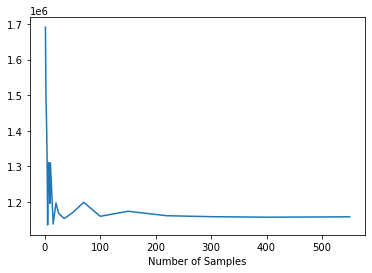

In [278]:
# converge_Series = 
pd.Series(data = test_vals*-1, index = num_sces).plot.line(
#         title = , 
    )

In [277]:
converge_Series.T.to_excel('converge_test_500samples.xlsx')

In [271]:
converge_Series.index.names = ['Number of Samples']

In [276]:
plot_labels = {
        'x': 'Number of Samples', 
        'y': 'Objective Value [Euro]'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
fig = px.line(converge_Series, 
          x=converge_Series.index, 
          y=converge_Series, 
          title='Convergence of SAA',
          labels = plot_labels

     )

fig.show()

In [53]:
# Save solutions of all subscenario models to excel sheet. This can be very slow
csap_ef.write_tree_solution('efsol.xlsx')

ERROR: evaluating object as numeric value: '2'.calA[137,peak]
        (object: <class 'pyomo.core.base.param._ParamData'>)
ERROR: evaluating object as numeric value: '2'.w_cs2poi[178,94,peak]
        (object: <class 'pyomo.core.base.expression._GeneralExpressionData'>)


KeyboardInterrupt: 

In [84]:
# MPDP.display()

In [ ]:
import mpisppy.utils.sputils as sputils

def csap_scenario_creator(
    scenario_name,    
    mpdp_frame_data: dict,
    all_sces_dict: dict,
    linearize_model: bool = True,
    model_name: str = 'EVCSAP_MPSP'
    ) -> pyo.ConcreteModel:
    if not scenario_name in all_sces_dict.keys():
        raise ValueError("Unrecognized scenario index")
    
    connect_sce = all_sces_dict[scenario_name].stack().to_dict()

    # Build Pyomo.ConcreteModel instance MPSP
    # # Multi-Period Stochastic Mixed-Interger Linear Programming (MPS-P)
    model = _build_mpsp_csap_from_mpdp_frame( 
        mpdp_frame_data = mpdp_frame_data, 
        cs_ss_connect_sce = connect_sce,
        m_name = model_name, 
        linearized = linearize_model
    )

    # Define First Stage (Determinisitic) Node ()
    sputils.attach_root_node(
        model=model,
        firstobj = model.first_stage_cost,
        varlist = [model.x, model.y, model.z, # CS/CD first stage DVs
            model.x_hat, model.chi, model.calE, # Auxiliary first stage CS/CD DVs to linearize model
            model.h # SS first stage expansion DV
        ]
    )
    model._mpisppy_probability = 1.0 / len(all_sces_dict)
    
    return model


from mpisppy.opt.ef import ExtensiveForm
options = {"solver": "cplex"}
MPSP_ef = ExtensiveForm(
            options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs = {
                "mpdp_frame_data": frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
        )
solver_results = MPSP_ef.solve_extensive_form()

objval = ef.get_objective_value()
print(f"{objval:.1f}")
solution = ef.get_root_solution()
for (var_name, var_value) in solution.items():
print(var_name, var_value)

In [ ]:
## Store results in the dict
print("Storing test results ... ")
results_prob_descrip = results['Problem'][0]
results_solver_info = results['Solver'][0]
current_obj_val = results['Solution'][0]['Objective']['__default_objective__']['Value']

if SP == True:
    csap_subsces = csap_ef.scenarios()
    subsce_name, subscemodel = next(csap_subsce)
    SP_one_subscemodel_data = SupSP._get_data_from_frame_model(frame_model = subscemodel)
else:
    model_data = SupSP._get_data_from_frame_model(frame_model = model)
## Store CSAP decisions

test_result_dict[test_id] = {
    'num_scenarios': num_sces,
    'ids_scenarios': selected_sces_names,
    'objective_value' : current_obj_val,
    'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
    'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
    'gap' : results['Solution'][0]['Gap'], 
    'one_subsceModel_data' : SP_one_subscemodel_data
    # 'mpsp_csap_decisions': mpsp_decisions 
}
print('Done\n---------------------------------------\n')